<h1><center>P6 Classifiez automatiquement des biens de consommation</center></h1>


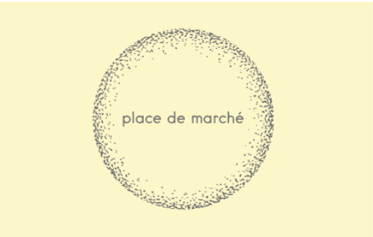

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import manifold, decomposition
import time
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def tokenizer_fct(sentence) :
    # print(sentence)
    word_tokens = word_tokenize(sentence)
    return word_tokens


In [4]:
def phrase_bow(phrase):
    return " ".join([word for word in phrase])


In [5]:
def exploration_csv(df):
    for col in df:
        print(col)
        print(df[col].nunique())
        print(df[col].unique()[:25])
        print('Valeurs manquantes :',df[col].isna().sum())
        print('Nombre de doublons :', int(len(df[df.duplicated()])))
        print()
        print('*'*25)

In [6]:
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [7]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=40)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(18,8))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [8]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [9]:
def TSNE_visu_fct_2(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(18,8))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    


In [10]:
def ARI_fct_2(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=40)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    
    
    return ARI, X_tsne, cls.labels_

In [11]:
# Function to build histogram of 1 image
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [12]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [13]:
df.shape

(1050, 15)

In [14]:
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [15]:
exploration_csv(df)

uniq_id
1050
['55b85ea15a1536d46b7190ad6fff8ce7' '7b72c92c2f6c40268628ec5f14c6d590'
 '64d5d4a258243731dc7bbb1eef49ad74' 'd4684dcdc759dd9cdf41504698d737d8'
 '6325b6870c54cd47be6ebfbffa620ec7' '893aa5ed55f7cff2eccea7758d7a86bd'
 'f355cc1ccb08bd0d283ed979b7ee7515' 'dd0e3470a7e6ed76fd69c2da27721041'
 '41384da51732c0b4df3de8f395714fbb' '710ed5f2393a4b9e8823aa0029f71f93'
 '920154acbe49d3202ed7d2ed2df1ea13' '08452abdadb3db1e686b94a9c52fc7b6'
 '1e8741b5ae27a513546c94b3f3312aee' '189fa66a5fa6f08d2802a62ecf0be298'
 'bbb8cdc5406ff60ff06ff64630f2ca47' '1120bc768623572513df956172ffefeb'
 '5479bb7028827d60000720a2c135976a' '733aa1e801a139fa8dc7be9f0eff5ee0'
 '62c35de4df27437d3597963fac55a8b6' '33d97d63c037078cd3f08033966d6a88'
 'd7ca2b06b4f4d3b98c61c377b18a2d6b' 'f74476ba64365d97a5be7d375cbf4c7a'
 'fda50982a672ef8835de5c1cc86f8bfc' '4788f5466992da09024b8ffcc8a5cba4'
 '653826cd53f1d9e2c086c0ac7846ef70']
Valeurs manquantes : 0
Nombre de doublons : 0

*************************
crawl_timestamp
149
['201

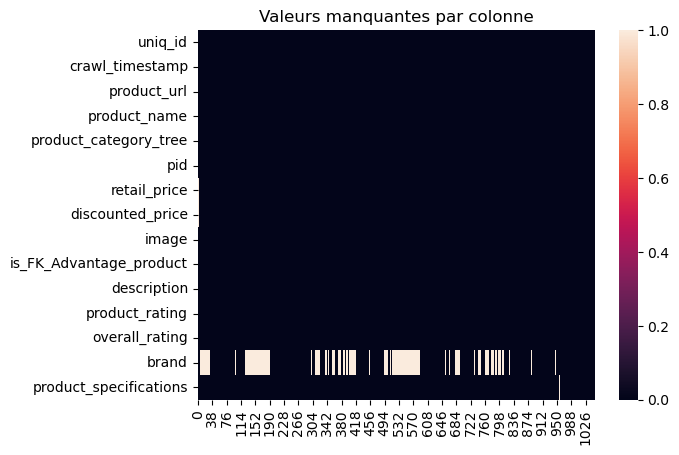

In [16]:
sns.heatmap(df.isna().T)
plt.title('Valeurs manquantes par colonne')
plt.show()

In [17]:
for col in df:
    print(col,'*'*25,df.duplicated(subset=col).sum())

uniq_id ************************* 0
crawl_timestamp ************************* 901
product_url ************************* 0
product_name ************************* 0
product_category_tree ************************* 408
pid ************************* 0
retail_price ************************* 695
discounted_price ************************* 625
image ************************* 0
is_FK_Advantage_product ************************* 1048
description ************************* 0
product_rating ************************* 1023
overall_rating ************************* 1023
brand ************************* 559
product_specifications ************************* 65


In [18]:
df.describe(include='all')

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
std       7639.229411       7475.099680                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000

In [19]:
df1 = df[['uniq_id','description','product_category_tree']];
df1

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                  product_category_tree  
0     ["Home Furnishing >> Curtains & Accessories >>...  
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  
...                                                 ...  
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  

[1050 rows x 3 columns]

In [20]:
df1['product_category_tree'].value_counts()

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1
Name: product_categor

<AxesSubplot: >

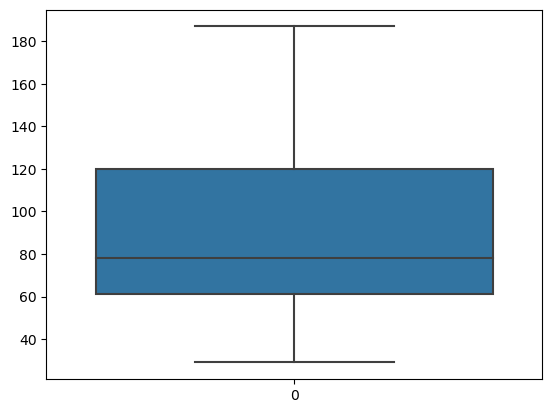

In [21]:
df1_tree = df1['product_category_tree'].str.len();
sns.boxplot(df1_tree)

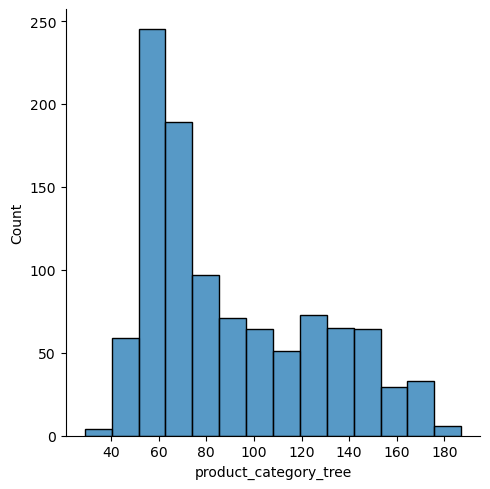

In [22]:
sns.displot(df1_tree)

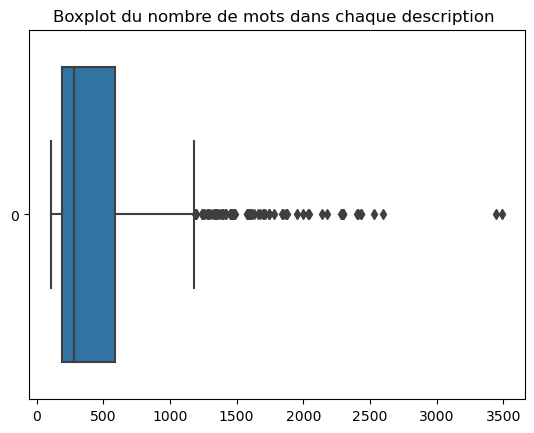

In [23]:
df1_des = df1['description'].str.len();
sns.boxplot(df1_des, orient='h',)
plt.title("Boxplot du nombre de mots dans chaque description ")
plt.show()

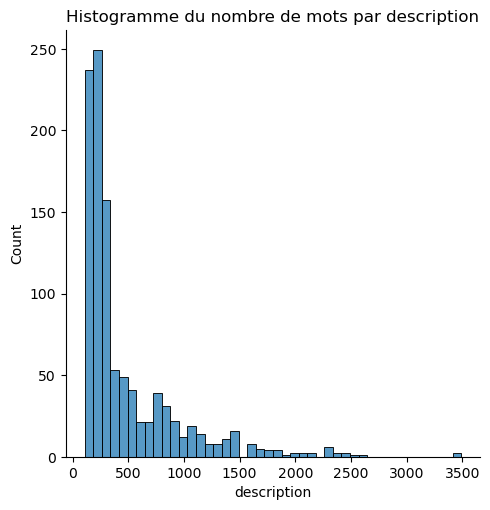

In [24]:
sns.displot(df1_des)
plt.title('Histogramme du nombre de mots par description')
plt.show()

# Découpage de la colonne category tree

In [25]:
# Formatage en minuscule
df1['product_category_tree'] = df1['product_category_tree'].str.lower()
df1['product_category_tree'] = df1['product_category_tree'].str.replace('"', '');
df1['product_category_tree'] = df1['product_category_tree'].str.replace('[', '').str.replace(']', '').str.replace('& ', '');
df1['product_category_tree'] = df1['product_category_tree'].str.replace('  ', ' ');
df2 = df1['product_category_tree'].str.split(pat=">>",expand=True)

C:\Users\sarah\AppData\Local\Temp\ipykernel_17132\2544590627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['product_category_tree'] = df1['product_category_tree'].str.lower()
C:\Users\sarah\AppData\Local\Temp\ipykernel_17132\2544590627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['product_category_tree'] = df1['product_category_tree'].str.replace('"', '');
C:\Users\sarah\AppData\Local\Temp\ipykernel_17132\2544590627.py:4: FutureWarning: The default value of regex will change from True t

In [26]:
df2

0                       1                   2  \
0     home furnishing    curtains accessories            curtains    
1           baby care          baby bath skin    baby bath towels    
2           baby care          baby bath skin    baby bath towels    
3     home furnishing               bed linen           bedsheets    
4     home furnishing               bed linen           bedsheets    
...                ...                     ...                 ...   
1045        baby care         baby kids gifts            stickers    
1046        baby care         baby kids gifts            stickers    
1047        baby care         baby kids gifts            stickers    
1048        baby care         baby kids gifts            stickers    
1049        baby care         baby kids gifts            stickers    

                                                      3  \
0      elegance polyester multicolor abstract eyelet...   
1                            sathiyas baby bath towels    
2                             eurospa baby bath towels    
3                      santosh royal fashion bedsheets    
4                               jaipur print bedsheets    
...                                                 ...   
1045                              oren empower stickers   
1046                                wallmantra stickers   
1047                                  uberlyfe stickers   
1048                                wallmantra stickers   
1049                                  uberlyfe stickers   

                                                      4     5     6  
0                                                  None  None  None  
1      sathiyas cotton bath towel (3 bath towel, red...  None  None  
2      eurospa cotton terry face towel set (20 piece...  None  None  
3      santosh royal fashion cotton printed king siz...  None  None  
4      jaipur print cotton floral king sized double ...  None  None  
...                                                 ...   ...   ...  
1045                                               None  None  None  
1046                                               None  None  None  
1047                                               None  None  None  
1048                                               None  None  None  
1049                                               None  None  None  

[1050 rows x 7 columns]

In [27]:
df1['niveau_1'] = df2[0]

C:\Users\sarah\AppData\Local\Temp\ipykernel_17132\2635025803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['niveau_1'] = df2[0]


In [28]:
df1.head(2)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   

                               product_category_tree          niveau_1  
0  home furnishing >> curtains accessories >> cur...  home furnishing   
1  baby care >> baby bath skin >> baby bath towel...        baby care

In [29]:
df1.groupby('niveau_1').count()['uniq_id'].sort_values(ascending=False)

niveau_1
baby care                    150
beauty and personal care     150
computers                    150
home decor festive needs     150
home furnishing              150
kitchen dining               150
watches                      150
Name: uniq_id, dtype: int64

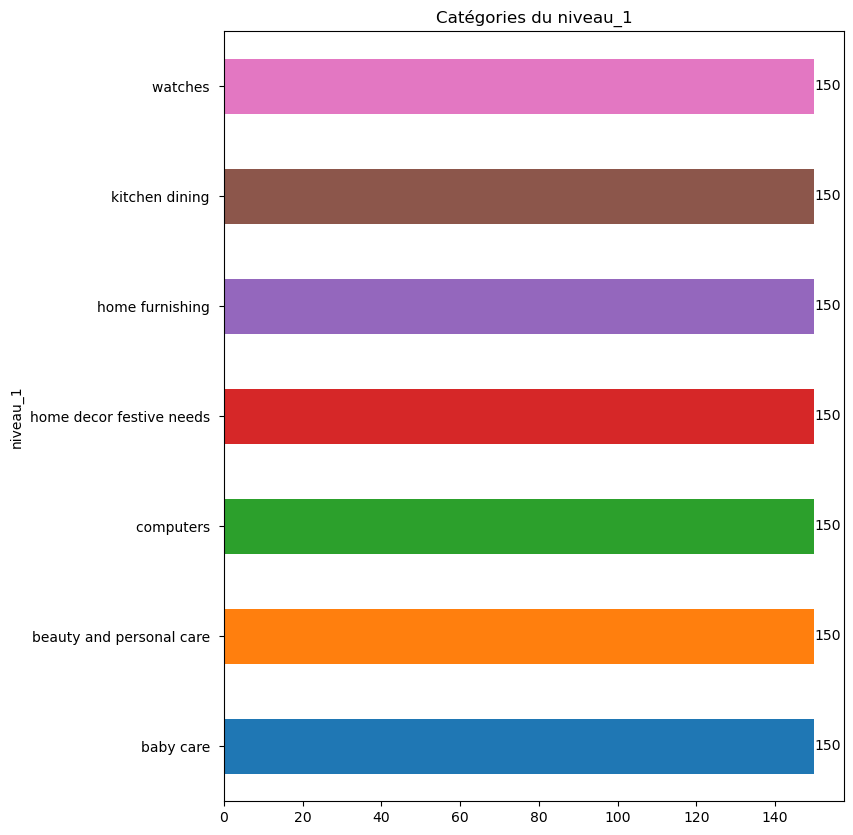

In [30]:
plt.figure(figsize=(8, 10))
ax0 = df1.groupby('niveau_1').count()['uniq_id'].sort_values(
    ascending=False).plot(kind='barh', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
ax0.bar_label(ax0.containers[0])
plt.title('Catégories du niveau_1')
plt.show()

# Traitement de la colonne description

In [31]:
df1.columns

Index(['uniq_id', 'description', 'product_category_tree', 'niveau_1'], dtype='object')

In [32]:
df1 = df1[['uniq_id', 'product_category_tree', 'niveau_1',
           'description']]

In [33]:
df1

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                  product_category_tree          niveau_1  \
0     home furnishing >> curtains accessories >> cur...  home furnishing    
1     baby care >> baby bath skin >> baby bath towel...        baby care    
2     baby care >> baby bath skin >> baby bath towel...        baby care    
3     home furnishing >> bed linen >> bedsheets >> s...  home furnishing    
4     home furnishing >> bed linen >> bedsheets >> j...  home furnishing    
...                                                 ...               ...   
1045  baby care >> baby kids gifts >> stickers >> or...        baby care    
1046  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1047  baby care >> baby kids gifts >> stickers >> ub...        baby care    
1048  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1049  baby care >> baby kids gifts >> stickers >> ub...        baby care    

                                            description  
0     Key Features of Elegance Polyester Multicolor ...  
1     Specifications of Sathiyas Cotton Bath Towel (...  
2     Key Features of Eurospa Cotton Terry Face Towe...  
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  
4     Key Features of Jaipur Print Cotton Floral Kin...  
...                                                 ...  
1045  Oren Empower Extra Large Self Adhesive Sticker...  
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...  
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...  

[1050 rows x 4 columns]

In [34]:
df1.iloc[0,-1]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [35]:
df1['description'] = df1['description'].str.lower()

In [36]:
df1.iloc[0,-1]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so that you

In [37]:
# Suppression de la ponctuation
df1['description'] = df1['description'].str.replace(r'[^\w\s]+', '')

C:\Users\sarah\AppData\Local\Temp\ipykernel_17132\35249305.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['description'] = df1['description'].str.replace(r'[^\w\s]+', '')


In [38]:
# Suppression des numéros
df1['description'] = df1['description'].str.replace('\d+', '')

C:\Users\sarah\AppData\Local\Temp\ipykernel_17132\2419830313.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['description'] = df1['description'].str.replace('\d+', '')


In [39]:
df1['description'] = df1['description'].replace(r'\s+', ' ', regex=True)

In [40]:
df1

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                  product_category_tree          niveau_1  \
0     home furnishing >> curtains accessories >> cur...  home furnishing    
1     baby care >> baby bath skin >> baby bath towel...        baby care    
2     baby care >> baby bath skin >> baby bath towel...        baby care    
3     home furnishing >> bed linen >> bedsheets >> s...  home furnishing    
4     home furnishing >> bed linen >> bedsheets >> j...  home furnishing    
...                                                 ...               ...   
1045  baby care >> baby kids gifts >> stickers >> or...        baby care    
1046  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1047  baby care >> baby kids gifts >> stickers >> ub...        baby care    
1048  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1049  baby care >> baby kids gifts >> stickers >> ub...        baby care    

                                            description  
0     key features of elegance polyester multicolor ...  
1     specifications of sathiyas cotton bath towel b...  
2     key features of eurospa cotton terry face towe...  
3     key features of santosh royal fashion cotton p...  
4     key features of jaipur print cotton floral kin...  
...                                                 ...  
1045  oren empower extra large self adhesive sticker...  
1046  wallmantra large vinyl sticker sticker pack of...  
1047  buy uberlyfe extra large pigmented polyvinyl f...  
1048  buy wallmantra medium vinyl sticker sticker fo...  
1049  buy uberlyfe large vinyl sticker for rs online...  

[1050 rows x 4 columns]

In [41]:
df1.iloc[0,-1]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm in height pack of price rs this curtain enhances the look of the interiorsthis curtain is made from high quality polyester fabricit features an eyelet style stitch with metal ringit makes the room environment romantic and lovingthis curtain is ant wrinkle and anti shrinkage and have elegant apparancegive your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlig

# Tokenisation de description

In [42]:
df1['token'] = df1['description'].apply(lambda x : tokenizer_fct(x))

In [43]:
df1.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                               product_category_tree          niveau_1  \
0  home furnishing >> curtains accessories >> cur...  home furnishing    
1  baby care >> baby bath skin >> baby bath towel...        baby care    
2  baby care >> baby bath skin >> baby bath towel...        baby care    
3  home furnishing >> bed linen >> bedsheets >> s...  home furnishing    
4  home furnishing >> bed linen >> bedsheets >> j...  home furnishing    

                                         description  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   
2  key features of eurospa cotton terry face towe...   
3  key features of santosh royal fashion cotton p...   
4  key features of jaipur print cotton floral kin...   

                                               token  
0  [key, features, of, elegance, polyester, multi...  
1  [specifications, of, sathiyas, cotton, bath, t...  
2  [key, features, of, eurospa, cotton, terry, fa...  
3  [key, features, of, santosh, royal, fashion, c...  
4  [key, features, of, jaipur, print, cotton, flo...

In [44]:
df1.iloc[0,4]

['key',
 'features',
 'of',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtainelegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'in',
 'height',
 'pack',
 'of',
 'price',
 'rs',
 'this',
 'curtain',
 'enhances',
 'the',
 'look',
 'of',
 'the',
 'interiorsthis',
 'curtain',
 'is',
 'made',
 'from',
 'high',
 'quality',
 'polyester',
 'fabricit',
 'features',
 'an',
 'eyelet',
 'style',
 'stitch',
 'with',
 'metal',
 'ringit',
 'makes',
 'the',
 'room',
 'environment',
 'romantic',
 'and',
 'lovingthis',
 'curtain',
 'is',
 'ant',
 'wrinkle',
 'and',
 'anti',
 'shrinkage',
 'and',
 'have',
 'elegant',
 'apparancegive',
 'your',
 'home',
 'a',
 'bright',
 'and',
 'modernistic',
 'appeal',
 'with',
 'these',
 'designs',
 'the',
 'surreal',
 'attention',
 'is',
 'sure',
 'to',
 'steal',
 'hearts',
 'these',
 'contemporary',
 'eyelet',
 'and',
 'valance',
 'curtains',
 'slide',
 'smoothly',
 '

# Suppression des stop-words

In [45]:
# Stop words
stop_w = list(set(stopwords.words('english')))


In [46]:
df1['stop_words'] = df1['token'].apply(lambda x:[word for word in x if word not in stop_w and word.isalnum()])


In [47]:
df1['clean'] = df1['stop_words'].apply(lambda x : phrase_bow(x))


In [48]:
l_cat = list(set(df1['niveau_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df1.iloc[i]['niveau_1'])) for i in range(len(df1))]

catégories :  ['kitchen dining ', 'beauty and personal care ', 'watches ', 'baby care ', 'home furnishing ', 'computers ', 'home decor festive needs ']


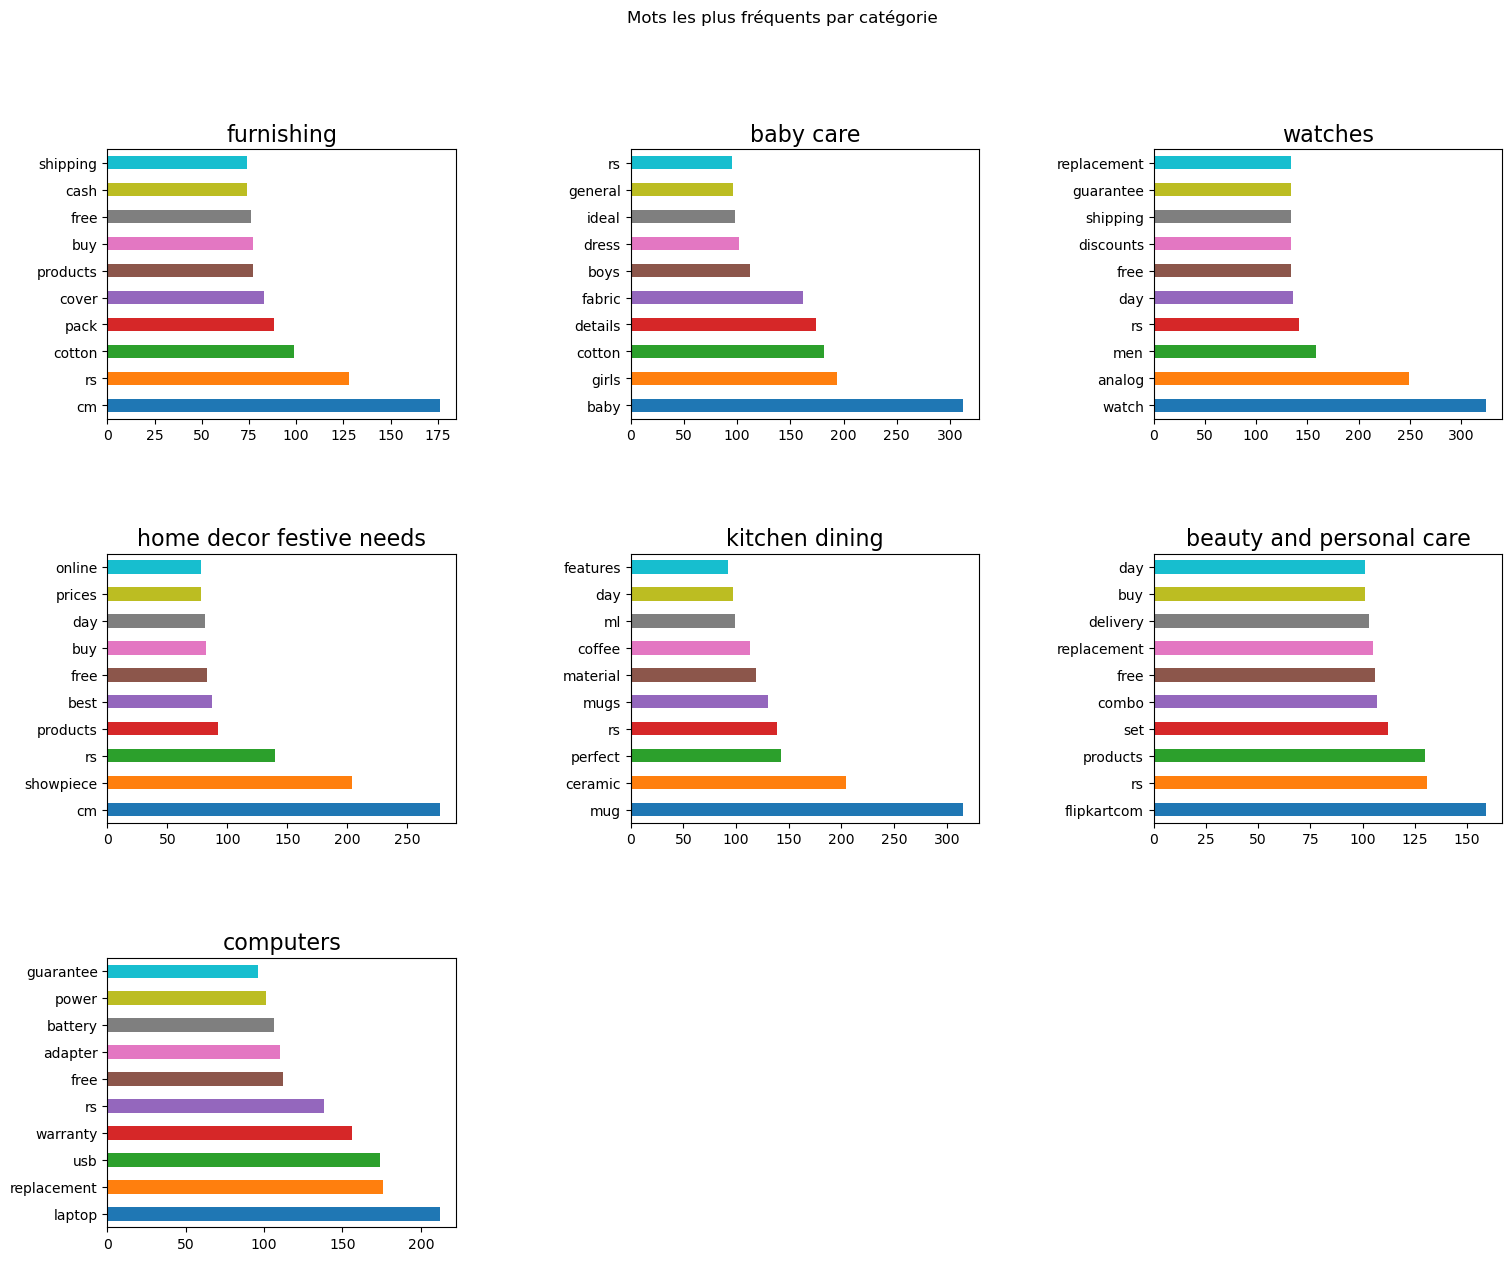

In [49]:
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

fig.suptitle('Mots les plus fréquents par catégorie')

df1.loc[df1['niveau_1'].str.contains('furnishing')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh', ax =axes[0,0],color=color,);
axes[0,0].set_title('furnishing',size=16)

df1.loc[df1['niveau_1'].str.contains('baby care')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh', ax =axes[0,1],color=color);
axes[0,1].set_title('baby care',size=16)

df1.loc[df1['niveau_1'].str.contains('watches')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh', ax =axes[0,2],color=color);
axes[0,2].set_title('watches',size=16)

df1.loc[df1['niveau_1'].str.contains('home decor festive needs')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh',color=color, ax =axes[1,0]);
axes[1,0].set_title('home decor festive needs',size=16)

df1.loc[df1['niveau_1'].str.contains('kitchen dining')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh', ax =axes[1,1],color=color);
axes[1,1].set_title('kitchen dining',size=16)

df1.loc[df1['niveau_1'].str.contains('beauty and personal care')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh', ax =axes[1,2],color=color);
axes[1,2].set_title('beauty and personal care',size=16)

df1.loc[df1['niveau_1'].str.contains('computers')]['clean'].str.split(expand=True).stack().value_counts()[:10].plot(kind='barh', ax =axes[2,0],color=color);
axes[2,0].set_title('computers',size=16)

fig.delaxes(ax=axes[2,1])
fig.delaxes(ax=axes[2,2])



plt.show()

In [50]:
new_stopwords = ["cm", "flipkartcom", "rs","free","buy","day","products","shipping","sales",
                 "delivery","cash","online","price","prices","guarantee","number","pack","key","features"]
#"key","features"

In [51]:
stop_w.extend(new_stopwords)

In [52]:
df1['stop_words_up'] = df1['token'].apply(lambda x:[word for word in x if word not in stop_w and word.isalnum()])


In [53]:
df1['clean_up'] = df1['stop_words_up'].apply(lambda x : phrase_bow(x))

In [54]:
df1.iloc[0,8]

'elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain height curtain enhances look interiorsthis curtain made high quality polyester fabricit eyelet style stitch metal ringit makes room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain height general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimensions length box contents package package curtains body de

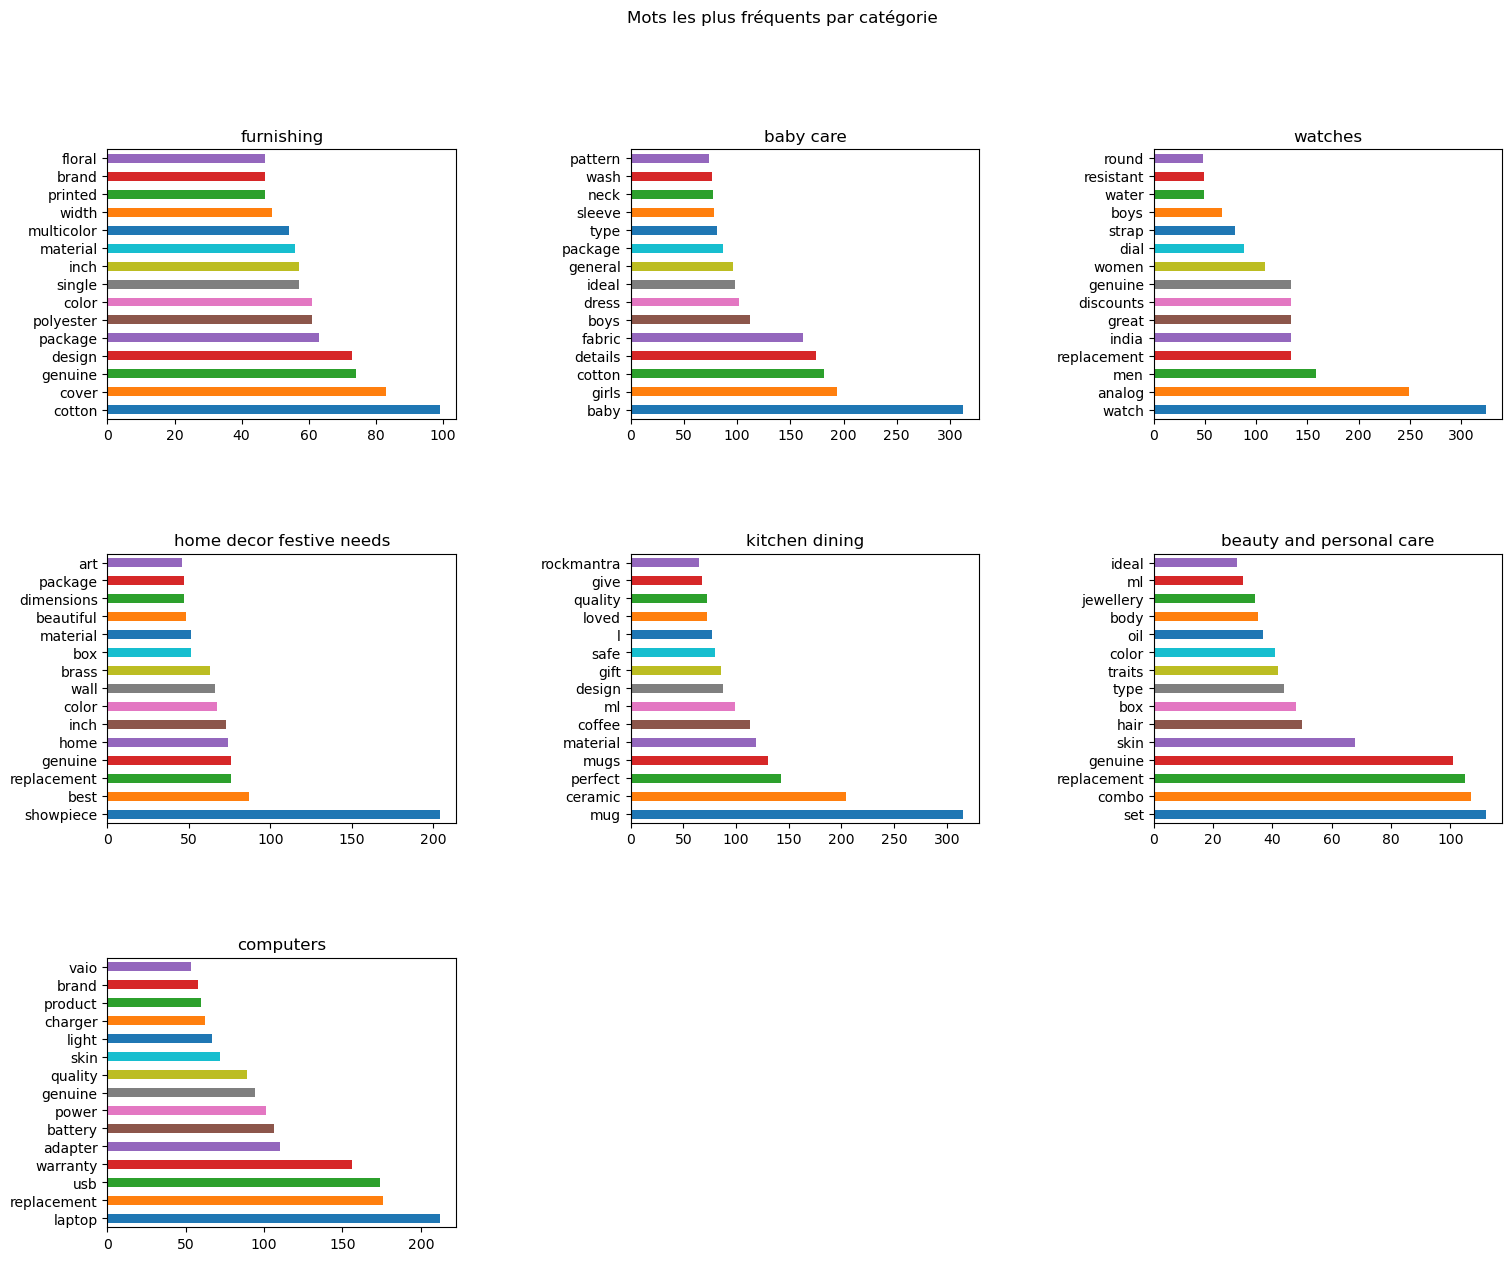

In [55]:
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

fig.suptitle('Mots les plus fréquents par catégorie')

df1.loc[df1['niveau_1'].str.contains('furnishing')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[0,0],);
axes[0,0].set_title('furnishing')

df1.loc[df1['niveau_1'].str.contains('baby care')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[0,1]);
axes[0,1].set_title('baby care')

df1.loc[df1['niveau_1'].str.contains('watches')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[0,2]);
axes[0,2].set_title('watches')

df1.loc[df1['niveau_1'].str.contains('home decor festive needs')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[1,0]);
axes[1,0].set_title('home decor festive needs')

df1.loc[df1['niveau_1'].str.contains('kitchen dining')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[1,1]);
axes[1,1].set_title('kitchen dining')

df1.loc[df1['niveau_1'].str.contains('beauty and personal care')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[1,2]);
axes[1,2].set_title('beauty and personal care')

df1.loc[df1['niveau_1'].str.contains('computers')]['clean_up'].str.split(expand=True).stack().value_counts()[:15].plot(kind='barh',color=color, ax =axes[2,0]);
axes[2,0].set_title('computers')

fig.delaxes(ax=axes[2,1])
fig.delaxes(ax=axes[2,2])
plt.show()







In [56]:
df1['clean_up'].str.split(expand=True).stack().value_counts()[:15]

genuine        564
replacement    559
watch          330
mug            319
color          317
baby           316
material       306
type           303
set            303
box            289
general        288
cotton         286
package        268
analog         255
warranty       244
dtype: int64

In [57]:
df1.iloc[0,7]

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtainelegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'curtain',
 'enhances',
 'look',
 'interiorsthis',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabricit',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ringit',
 'makes',
 'room',
 'environment',
 'romantic',
 'lovingthis',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparancegive',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'designs',
 'surreal',
 'attention',
 'sure',
 'steal',
 'hearts',
 'contemporary',
 'eyelet',
 'valance',
 'curtains',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'rays',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moments',
 'joyous',
 'beauty',
 'given',
 'soothing',
 'prints',
 'bring',
 '

# Stemming

In [58]:
stemmer = nltk.stem.PorterStemmer()

In [59]:
df1['stemmer'] = df1.apply(lambda row : [stemmer.stem(w) for w in row['stop_words_up']], axis=1)


In [60]:
df1.iloc[0,-1]

['eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtaineleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'curtain',
 'enhanc',
 'look',
 'interiorsthi',
 'curtain',
 'made',
 'high',
 'qualiti',
 'polyest',
 'fabricit',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ringit',
 'make',
 'room',
 'environ',
 'romant',
 'lovingthi',
 'curtain',
 'ant',
 'wrinkl',
 'anti',
 'shrinkag',
 'eleg',
 'apparanceg',
 'home',
 'bright',
 'modernist',
 'appeal',
 'design',
 'surreal',
 'attent',
 'sure',
 'steal',
 'heart',
 'contemporari',
 'eyelet',
 'valanc',
 'curtain',
 'slide',
 'smoothli',
 'draw',
 'apart',
 'first',
 'thing',
 'morn',
 'welcom',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morn',
 'whole',
 'world',
 'draw',
 'close',
 'even',
 'creat',
 'special',
 'moment',
 'joyou',
 'beauti',
 'given',
 'sooth',
 'print',
 'bring',
 'home',
 'eleg',
 'curtain',
 'softli',
 'filter',
 'light',


# Lemmatizer

In [61]:
# Lemmatizer (base d'un mot)
df1['lemmatizer'] = df1['stop_words_up'].apply(lambda x : lemma_fct(x))

In [62]:
df1.iloc[0,-1]

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtainelegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'curtain',
 'enhances',
 'look',
 'interiorsthis',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabricit',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ringit',
 'make',
 'room',
 'environment',
 'romantic',
 'lovingthis',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparancegive',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moment',
 'joyous',
 'beauty',
 'given',
 'soothing',
 'print',
 'bring',
 'home',


In [63]:
long_max = max(df1['token'].apply(lambda row : len(row)));
long_max_stem = max(df1['stemmer'].apply(lambda row : len(row)))
long_max_lem = max(df1['lemmatizer'].apply(lambda row : len(row)))
print(long_max)
print(long_max_stem)
print(long_max_lem)

562
352
352


In [64]:
df1['clean_lem'] = df1['lemmatizer'].apply(lambda x : phrase_bow(x))
df1['clean_stem'] = df1['stemmer'].apply(lambda x : phrase_bow(x))

In [65]:
df1

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                  product_category_tree          niveau_1  \
0     home furnishing >> curtains accessories >> cur...  home furnishing    
1     baby care >> baby bath skin >> baby bath towel...        baby care    
2     baby care >> baby bath skin >> baby bath towel...        baby care    
3     home furnishing >> bed linen >> bedsheets >> s...  home furnishing    
4     home furnishing >> bed linen >> bedsheets >> j...  home furnishing    
...                                                 ...               ...   
1045  baby care >> baby kids gifts >> stickers >> or...        baby care    
1046  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1047  baby care >> baby kids gifts >> stickers >> ub...        baby care    
1048  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1049  baby care >> baby kids gifts >> stickers >> ub...        baby care    

                                            description  \
0     key features of elegance polyester multicolor ...   
1     specifications of sathiyas cotton bath towel b...   
2     key features of eurospa cotton terry face towe...   
3     key features of santosh royal fashion cotton p...   
4     key features of jaipur print cotton floral kin...   
...                                                 ...   
1045  oren empower extra large self adhesive sticker...   
1046  wallmantra large vinyl sticker sticker pack of...   
1047  buy uberlyfe extra large pigmented polyvinyl f...   
1048  buy wallmantra medium vinyl sticker sticker fo...   
1049  buy uberlyfe large vinyl sticker for rs online...   

                                                  token  \
0     [key, features, of, elegance, polyester, multi...   
1     [specifications, of, sathiyas, cotton, bath, t...   
2     [key, features, of, eurospa, cotton, terry, fa...   
3     [key, features, of, santosh, royal, fashion, c...   
4     [key, features, of, jaipur, print, cotton, flo...   
...                                                 ...   
1045  [oren, empower, extra, large, self, adhesive, ...   
1046  [wallmantra, large, vinyl, sticker, sticker, p...   
1047  [buy, uberlyfe, extra, large, pigmented, polyv...   
1048  [buy, wallmantra, medium, vinyl, sticker, stic...   
1049  [buy, uberlyfe, large, vinyl, sticker, for, rs...   

                                             stop_words  \
0     [key, features, elegance, polyester, multicolo...   
1     [specifications, sathiyas, cotton, bath, towel...   
2     [key, features, eurospa, cotton, terry, face, ...   
3     [key, features, santosh, royal, fashion, cotto...   
4     [key, features, jaipur, print, cotton, floral,...   
...                                                 ...   
1045  [oren, empower, extra, large, self, adhesive, ...   
1046  [wallmantra, large, vinyl, sticker, sticker, p...   
1047  [buy, uberlyfe, extra, large, pigmented, polyv...   
1048  [buy, wallmantra, medium, vinyl, sticker, stic...   
1049  [buy, uberlyfe, large, vinyl, sticker, rs, onl...   

                                                  clean  \
0     key features elegance polyester multicolor abs...   
1     specifications sathiyas cotton bath towel bath...   
2     key features eurospa cotton terry face towel s...   
3     key features santosh royal fashion cotton prin...   
4     key features jaipur print cotton floral king s...   
...                                                 ...   
1045  oren empower extra large self adhesive sticker...   
10

# Bag of word - Tf-idf

In [66]:
df1.head(2)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   

                               product_category_tree          niveau_1  \
0  home furnishing >> curtains accessories >> cur...  home furnishing    
1  baby care >> baby bath skin >> baby bath towel...        baby care    

                                         description  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   

                                               token  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                          stop_words  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                               clean  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel bath...   

                                       stop_words_up  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            clean_up  \
0  elegance polyester multicolor abstract eyelet ...   
1  specifications sathiyas cotton bath towel bath...   

                                             stemmer  \
0  [eleg, polyest, multicolor, abstract, eyelet, ...   
1  [specif, sathiya, cotton, bath, towel, bath, t...   

                                          lemmatizer  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [specification, sathiyas, cotton, bath, towel,...   

                                           clean_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  specification sathiyas cotton bath towel bath ...   

                                          clean_stem  
0  eleg polyest multicolor abstract eyelet door c...  
1  specif sathiya cotton bath towel bath towel re...

In [67]:
df1.niveau_1.unique()

array(['home furnishing ', 'baby care ', 'watches ',
       'home decor festive needs ', 'kitchen dining ',
       'beauty and personal care ', 'computers '], dtype=object)

# Fichier clean avec lem

In [68]:
# Création d'une boucle pour calculer le nombre optimal pour max_df et min_df
max_df = [0.5, 0.75, 0.9]
min_df = [1, 2, 5,7, 10]

df_results = pd.DataFrame(
    columns=["max_df", "min_df", "ARI_cv", "ARI_ctf"])

results = []
for i in max_df:
    for j in min_df:
        cvect = CountVectorizer(stop_words=stop_w, max_df=i, min_df=j)
        ctf = TfidfVectorizer(stop_words=stop_w, max_df=i, min_df=j)
        
        feat_1 = 'clean_lem'
        cv_fit = cvect.fit(df1[feat_1])
        ctf_fit = ctf.fit(df1[feat_1])
        
        
        cv_transform = cvect.transform(df1[feat_1])  
        ARI_cv, X_tsne, labels = ARI_fct(cv_transform)
        
        ctf_transform = ctf.transform(df1[feat_1])
        
        
        ARI_ctf, X_tsne, labels = ARI_fct(ctf_transform)
        
        results.append([i,j,ARI_cv,ARI_ctf])
        essai = pd.DataFrame(results, columns=["max_df", "min_df", "ARI_cv", "ARI_ctf"])
    df_results = pd.concat([df_results,essai])

ARI :  0.4552 time :  7.0
ARI :  0.5384 time :  5.0
ARI :  0.4581 time :  7.0
ARI :  0.5489 time :  5.0
ARI :  0.4966 time :  7.0
ARI :  0.5115 time :  6.0
ARI :  0.463 time :  6.0
ARI :  0.5311 time :  5.0
ARI :  0.4353 time :  7.0
ARI :  0.6243 time :  6.0
ARI :  0.4192 time :  7.0
ARI :  0.5252 time :  6.0
ARI :  0.4676 time :  7.0
ARI :  0.5531 time :  6.0
ARI :  0.4229 time :  7.0
ARI :  0.5018 time :  6.0
ARI :  0.523 time :  7.0
ARI :  0.5168 time :  5.0
ARI :  0.5232 time :  6.0
ARI :  0.6274 time :  5.0
ARI :  0.4192 time :  7.0
ARI :  0.5252 time :  5.0
ARI :  0.4676 time :  7.0
ARI :  0.5531 time :  6.0
ARI :  0.4229 time :  7.0
ARI :  0.5018 time :  5.0
ARI :  0.523 time :  7.0
ARI :  0.5168 time :  5.0
ARI :  0.5232 time :  7.0
ARI :  0.6274 time :  5.0


In [69]:
df_results.sort_values('ARI_ctf',ascending=False)

max_df min_df  ARI_cv  ARI_ctf
14    0.90     10  0.5232   0.6274
9     0.75     10  0.5232   0.6274
9     0.75     10  0.5232   0.6274
4     0.50     10  0.4353   0.6243
4     0.50     10  0.4353   0.6243
4     0.50     10  0.4353   0.6243
11    0.90      2  0.4676   0.5531
6     0.75      2  0.4676   0.5531
6     0.75      2  0.4676   0.5531
1     0.50      2  0.4581   0.5489
1     0.50      2  0.4581   0.5489
1     0.50      2  0.4581   0.5489
0     0.50      1  0.4552   0.5384
0     0.50      1  0.4552   0.5384
0     0.50      1  0.4552   0.5384
3     0.50      7  0.4630   0.5311
3     0.50      7  0.4630   0.5311
3     0.50      7  0.4630   0.5311
5     0.75      1  0.4192   0.5252
5     0.75      1  0.4192   0.5252
10    0.90      1  0.4192   0.5252
8     0.75      7  0.5230   0.5168
13    0.90      7  0.5230   0.5168
8     0.75      7  0.5230   0.5168
2     0.50      5  0.4966   0.5115
2     0.50      5  0.4966   0.5115
2     0.50      5  0.4966   0.5115
7     0.75      5  0.4229   0.5018
7     0.75      5  0.4229   0.5018
12    0.90      5  0.4229   0.5018

In [70]:
# création du bag of words (CountVectorizer et Tf-idf) avec max_df et min_df optiminsés

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect_lem = CountVectorizer(stop_words=stop_w, max_df=0.90, min_df=10)
ctf_lem = TfidfVectorizer(stop_words=stop_w, max_df=0.90, min_df=10)

feat_1 = 'clean_lem'
cv_fit_1 = cvect_lem.fit(df1[feat_1])
ctf_fit_1 = ctf_lem.fit(df1[feat_1])

cv_transform = cvect_lem.transform(df1[feat_1])  
ctf_transform = ctf_lem.transform(df1[feat_1])  

# Exécution des modèles

CountVectorizer : 
-----------------
ARI :  0.5232 time :  7.0


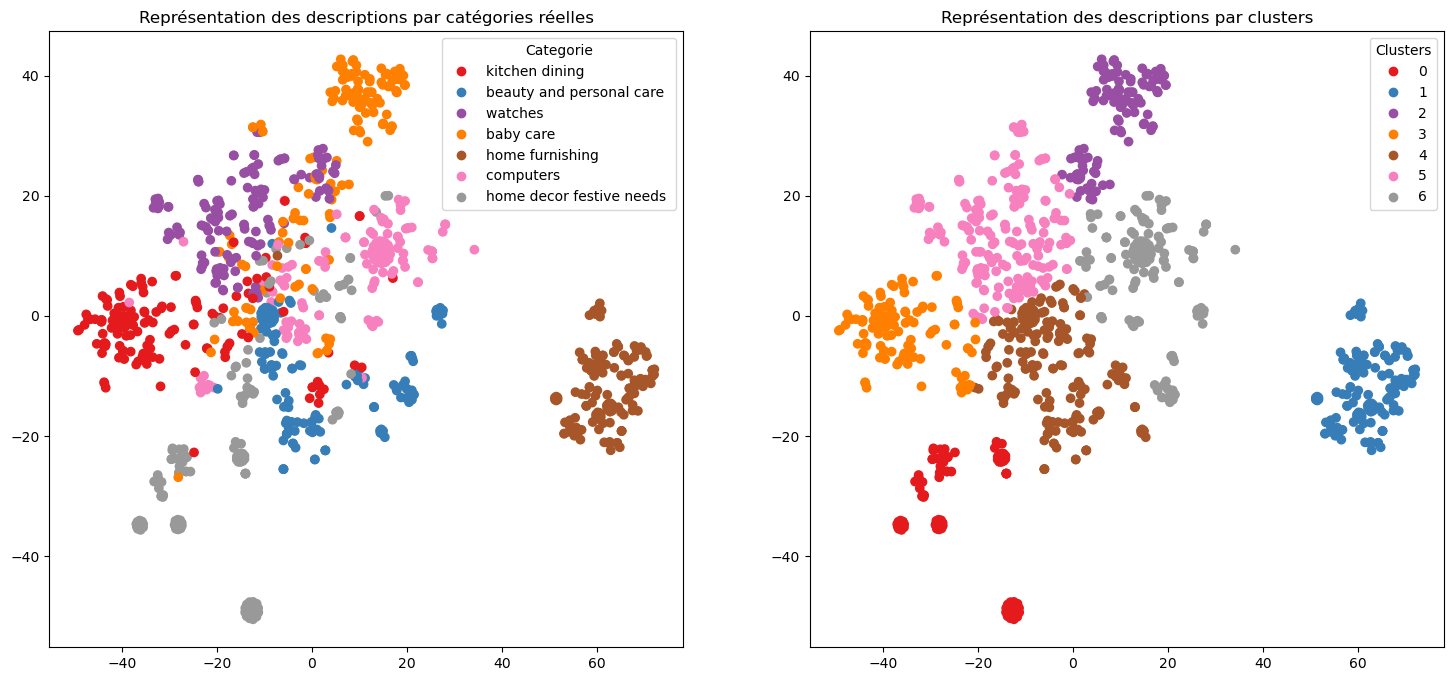

ARI :  0.5232


In [71]:
print("CountVectorizer : ")
print("-----------------")
ARI_cv_lem, X_tsne_cv_lem, labels_cvt = ARI_fct(cv_transform)
TSNE_visu_fct(X_tsne_cv_lem, y_cat_num, labels_cvt, ARI_cv_lem)


In [72]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df1['categ_encode'] = le.fit_transform(df1['niveau_1'])

In [73]:
df1['label_cvt'] = labels_cvt

In [74]:
df1

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                  product_category_tree          niveau_1  \
0     home furnishing >> curtains accessories >> cur...  home furnishing    
1     baby care >> baby bath skin >> baby bath towel...        baby care    
2     baby care >> baby bath skin >> baby bath towel...        baby care    
3     home furnishing >> bed linen >> bedsheets >> s...  home furnishing    
4     home furnishing >> bed linen >> bedsheets >> j...  home furnishing    
...                                                 ...               ...   
1045  baby care >> baby kids gifts >> stickers >> or...        baby care    
1046  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1047  baby care >> baby kids gifts >> stickers >> ub...        baby care    
1048  baby care >> baby kids gifts >> stickers >> wa...        baby care    
1049  baby care >> baby kids gifts >> stickers >> ub...        baby care    

                                            description  \
0     key features of elegance polyester multicolor ...   
1     specifications of sathiyas cotton bath towel b...   
2     key features of eurospa cotton terry face towe...   
3     key features of santosh royal fashion cotton p...   
4     key features of jaipur print cotton floral kin...   
...                                                 ...   
1045  oren empower extra large self adhesive sticker...   
1046  wallmantra large vinyl sticker sticker pack of...   
1047  buy uberlyfe extra large pigmented polyvinyl f...   
1048  buy wallmantra medium vinyl sticker sticker fo...   
1049  buy uberlyfe large vinyl sticker for rs online...   

                                                  token  \
0     [key, features, of, elegance, polyester, multi...   
1     [specifications, of, sathiyas, cotton, bath, t...   
2     [key, features, of, eurospa, cotton, terry, fa...   
3     [key, features, of, santosh, royal, fashion, c...   
4     [key, features, of, jaipur, print, cotton, flo...   
...                                                 ...   
1045  [oren, empower, extra, large, self, adhesive, ...   
1046  [wallmantra, large, vinyl, sticker, sticker, p...   
1047  [buy, uberlyfe, extra, large, pigmented, polyv...   
1048  [buy, wallmantra, medium, vinyl, sticker, stic...   
1049  [buy, uberlyfe, large, vinyl, sticker, for, rs...   

                                             stop_words  \
0     [key, features, elegance, polyester, multicolo...   
1     [specifications, sathiyas, cotton, bath, towel...   
2     [key, features, eurospa, cotton, terry, face, ...   
3     [key, features, santosh, royal, fashion, cotto...   
4     [key, features, jaipur, print, cotton, floral,...   
...                                                 ...   
1045  [oren, empower, extra, large, self, adhesive, ...   
1046  [wallmantra, large, vinyl, sticker, sticker, p...   
1047  [buy, uberlyfe, extra, large, pigmented, polyv...   
1048  [buy, wallmantra, medium, vinyl, sticker, stic...   
1049  [buy, uberlyfe, large, vinyl, sticker, rs, onl...   

                                                  clean  \
0     key features elegance polyester multicolor abs...   
1     specifications sathiyas cotton bath towel bath...   
2     key features eurospa cotton terry face towel s...   
3     key features santosh royal fashion cotton prin...   
4     key features jaipur print cotton floral king s...   
...                                                 ...   
1045  oren empower extra large self adhesive sticker...   
10

In [75]:
from sklearn.metrics import confusion_matrix

conf_matrix_cvt = confusion_matrix(df1['categ_encode'], df1['label_cvt'])

In [76]:
conf_matrix_cvt

array([[  1,   0,  95,   2,  21,  28,   3],
       [  0,   0,   0,   9,  26,  13, 102],
       [  0,   0,   0,   0, 114,   1,  35],
       [  1,   0,   0, 108,  21,  17,   3],
       [  0,   0,  22,   0,   0, 128,   0],
       [ 93,   0,   0,   1,  29,  10,  17],
       [  0, 149,   0,   0,   0,   1,   0]], dtype=int64)

In [77]:
conf_cvt = pd.DataFrame(conf_matrix_cvt,index=df1['niveau_1'].unique(),columns=df1['label_cvt'].unique())
conf_cvt

5    2   1    6    4    0    3
home furnishing             1    0  95    2   21   28    3
baby care                   0    0   0    9   26   13  102
watches                     0    0   0    0  114    1   35
home decor festive needs    1    0   0  108   21   17    3
kitchen dining              0    0  22    0    0  128    0
beauty and personal care   93    0   0    1   29   10   17
computers                   0  149   0    0    0    1    0

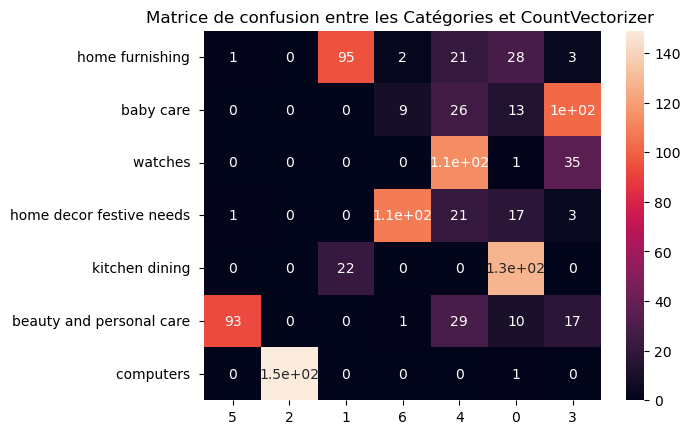

In [78]:
sns.heatmap(conf_cvt,annot=True,xticklabels=True, yticklabels=True)
plt.title('Matrice de confusion entre les Catégories et CountVectorizer ')
plt.show()

Tf-idf : 
--------
ARI :  0.6274 time :  5.0


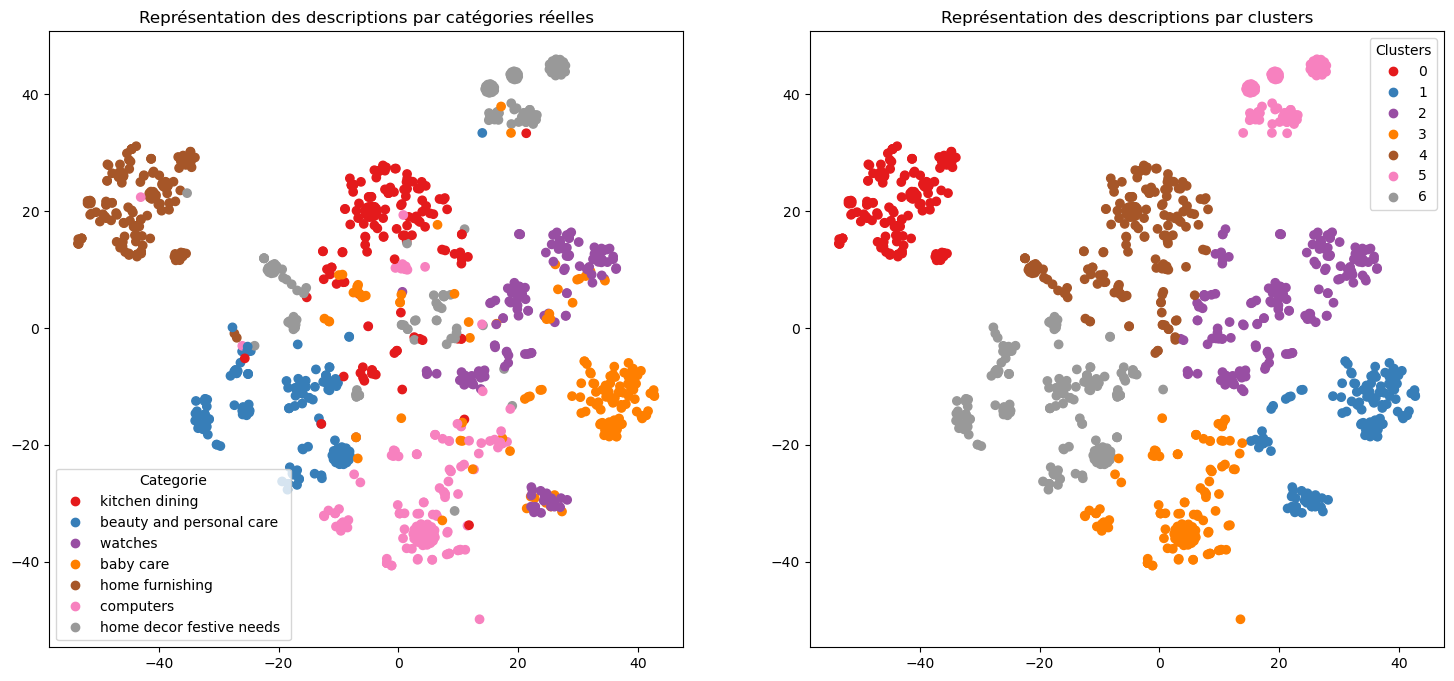

ARI :  0.6274


In [79]:
print("Tf-idf : ")
print("--------")
ARI_tdif_lem, X_tsne_tdif_lem, labels_lem = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne_tdif_lem, y_cat_num, labels_lem, ARI_tdif_lem)

In [80]:
df1['label_tdif'] = labels_lem

In [81]:
conf_matrix_tdif = confusion_matrix(df1['categ_encode'], df1['label_tdif'])
conf_tdif = pd.DataFrame(conf_matrix_tdif,index=df1['niveau_1'].unique(),columns=df1['label_tdif'].unique())
conf_tdif

2    1    0    6    3   4    5
home furnishing              0  107   16    7   17   2    1
baby care                    1   10    2  124   11   0    2
watches                      0    0    0    0    0   1  149
home decor festive needs     0    0   14    2  119   1   14
kitchen dining               0   20  129    0    1   0    0
beauty and personal care     1    1   20    1   34  74   19
computers                  148    0    0    0    0   0    2

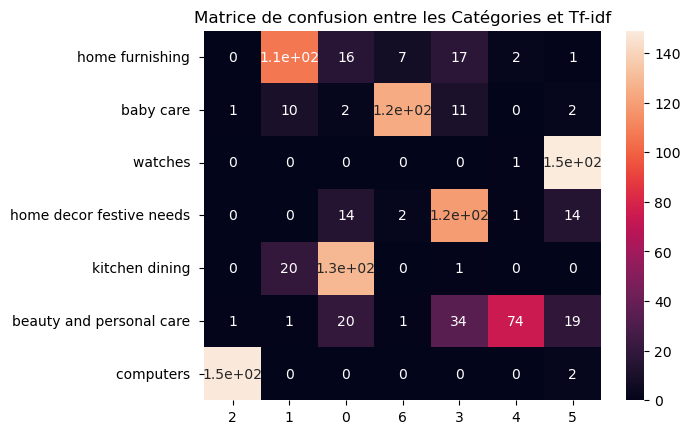

In [82]:
sns.heatmap(conf_tdif,annot=True)
plt.title('Matrice de confusion entre les Catégories et Tf-idf')
plt.show()

# Word2Vec

In [83]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

# Création du modèle Word2Vec

# Clean

In [84]:
len(df1.clean_up.max())

69

In [85]:
w2v_size_clean=100
w2v_window_clean=5
w2v_min_count_clean=1
w2v_epochs_clean=150
maxlen_clean = 69
sentences_clean = df1['clean_up'].to_list()
sentences_clean = [gensim.utils.simple_preprocess(text) for text in sentences_clean]

In [86]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model_clean = gensim.models.Word2Vec(min_count=w2v_min_count_clean, window=w2v_window_clean,
                                                vector_size=w2v_size_clean,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model_clean.build_vocab(sentences_clean)
w2v_model_clean.train(sentences_clean, total_examples=w2v_model_clean.corpus_count, epochs=w2v_epochs_clean)
model_vectors_clean = w2v_model_clean.wv
w2v_words_clean = model_vectors_clean.index_to_key
print("Vocabulary size: %i" % len(w2v_words_clean))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 5310
Word2Vec trained


In [87]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer_clean = Tokenizer()
tokenizer_clean.fit_on_texts(sentences_clean)
x_sentences_clean = pad_sequences(tokenizer_clean.texts_to_sequences(sentences_clean),
                                                     maxlen=maxlen_clean,
                                                     padding='post') 
                                                   
num_words_clean = len(tokenizer_clean.word_index) + 1
print("Number of unique words: %i" % num_words_clean)

Fit Tokenizer ...
Number of unique words: 5311


In [88]:
x_sentences_clean

array([[ 521, 1308, 1309, ...,   24,    7,  108],
       [  41, 1872,   12, ...,    0,    0,    0],
       [  53,   56,   53, ...,  214,  109,    9],
       ...,
       [1868,  674,  446, ...,    0,    0,    0],
       [ 519,  327,  244, ...,    0,    0,    0],
       [1868,  446,  244, ...,    0,    0,    0]])

# Création de la matrice d'embedding

In [89]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size_clean = 100
word_index_clean = tokenizer_clean.word_index
vocab_size_clean = len(word_index_clean) + 1
embedding_matrix_clean = np.zeros((vocab_size_clean, w2v_size_clean))
i=0
j=0
    
for word, idx in word_index_clean.items():
    i +=1
    if word in w2v_words_clean:
        j +=1
        embedding_vector_clean = model_vectors_clean[word]
        if embedding_vector_clean is not None:
            embedding_matrix_clean[idx] = model_vectors_clean[word]
            
word_rate_clean = np.round(j/i,4)
print("Word embedding rate : ", word_rate_clean)
print("Embedding matrix: %s" % str(embedding_matrix_clean.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5311, 100)


# Création du modèle d'embedding

In [90]:
# Création du modèle

input=Input(shape=(len(x_sentences_clean),maxlen_clean),dtype='float64')
word_input_clean=Input(shape=(maxlen_clean,),dtype='float64')  
word_embedding_clean=Embedding(input_dim=vocab_size_clean,
                         output_dim=w2v_size_clean,
                         weights = [embedding_matrix_clean],
                         input_length=maxlen_clean)(word_input_clean)
word_vec_clean=GlobalAveragePooling1D()(word_embedding_clean)  
embed_model_clean = Model([word_input_clean],word_vec_clean)

embed_model_clean.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 69)]              0         
                                                                 
 embedding (Embedding)       (None, 69, 100)           531100    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 531,100
Trainable params: 531,100
Non-trainable params: 0
_________________________________________________________________


# Exécution du modèle

In [91]:
embeddings_clean = embed_model_clean.predict(x_sentences_clean)
embeddings_clean.shape

(1050, 100)

In [92]:
ARI_w2_clean, X_tsne_w2_clean, labels_w2 = ARI_fct(embeddings_clean)

ARI :  0.4691 time :  7.0


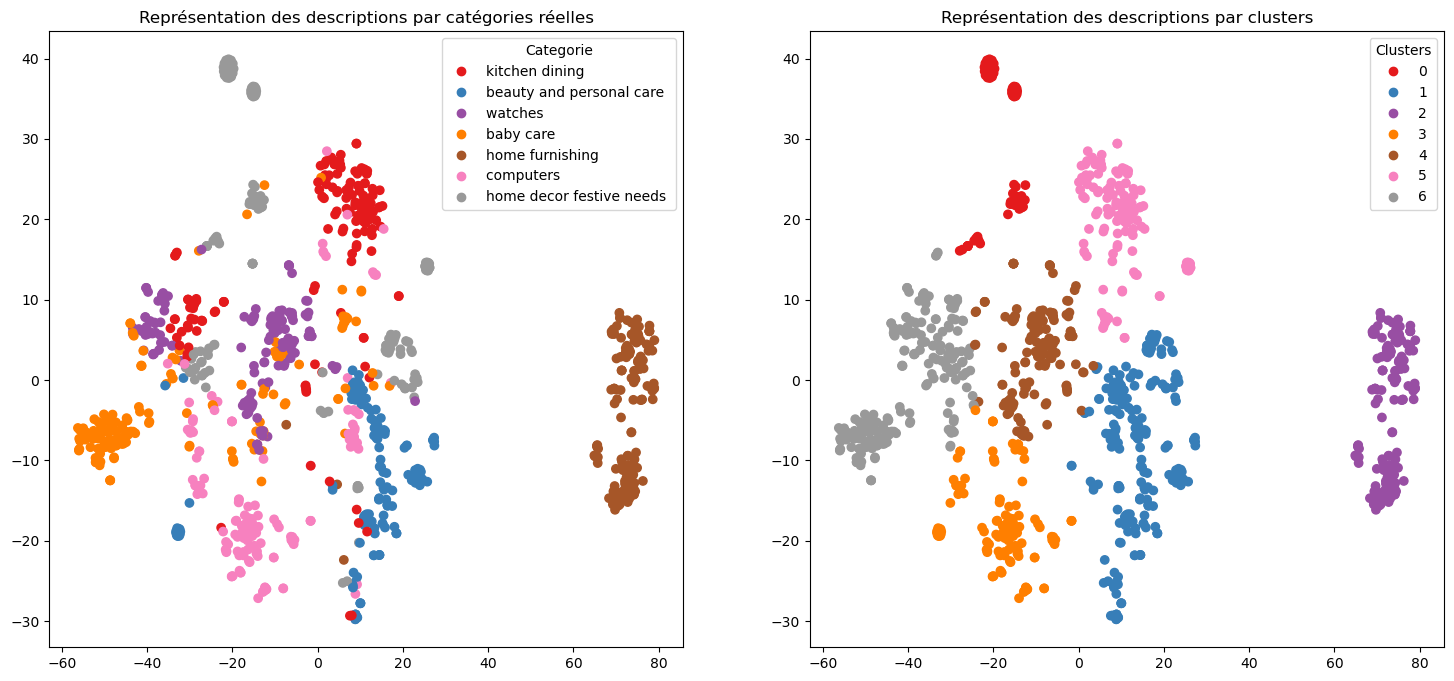

ARI :  0.4691


In [93]:
TSNE_visu_fct(X_tsne_w2_clean, y_cat_num, labels_w2, ARI_w2_clean)

In [94]:
df1['label_w2'] = labels_w2

conf_matrix_w2 = confusion_matrix(df1['categ_encode'], df1['label_w2'])
conf_w2 = pd.DataFrame(conf_matrix_w2,index=df1['niveau_1'].unique(),columns=df1['label_w2'].unique())
conf_w2

6    2    4    1   3   0   5
home furnishing             3    7    0    9  19  13  99
baby care                   0   22    0  105   1  11  11
watches                     0  137    0   11   0   0   2
home decor festive needs    0    9    0    1  14  98  28
kitchen dining              1    4    0    4  96   0  45
beauty and personal care   63   47    0    0   9  11  20
computers                   0    2  147    0   1   0   0

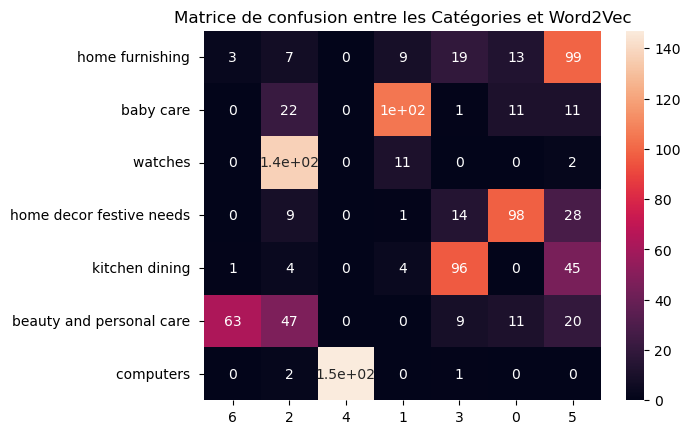

In [95]:
sns.heatmap(conf_w2,annot=True)
plt.title('Matrice de confusion entre les Catégories et Word2Vec')
plt.show()

# BERT

https://ledatascientist.com/a-la-decouverte-de-bert/

In [96]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\sarah\anaconda3\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\sarah\anaconda3\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [97]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.7.0
2.7.0
Num GPUs Available:  0
True


# BERT HuggingFace

## 'bert-base-uncased'

In [98]:
len(df1.clean_up.max())

69

In [99]:
max_length_clean = 32
batch_size_clean = 70
model_type = 'bert-base-uncased';
model = TFAutoModel.from_pretrained(model_type);
sentences_bert_clean = df1['clean_up'].to_list()


In [100]:
# Création des features

features_bert, last_hidden_states_tot_clean = feature_BERT_fct(model, model_type, sentences_bert_clean, 
                                                         max_length_clean, batch_size_clean, mode='HF')

temps traitement :  27.0


In [101]:
features_bert.shape

(1050, 768)

In [102]:
ARI_bert, X_tsne_bert, labels_bert = ARI_fct(features_bert)

ARI :  0.3606 time :  6.0


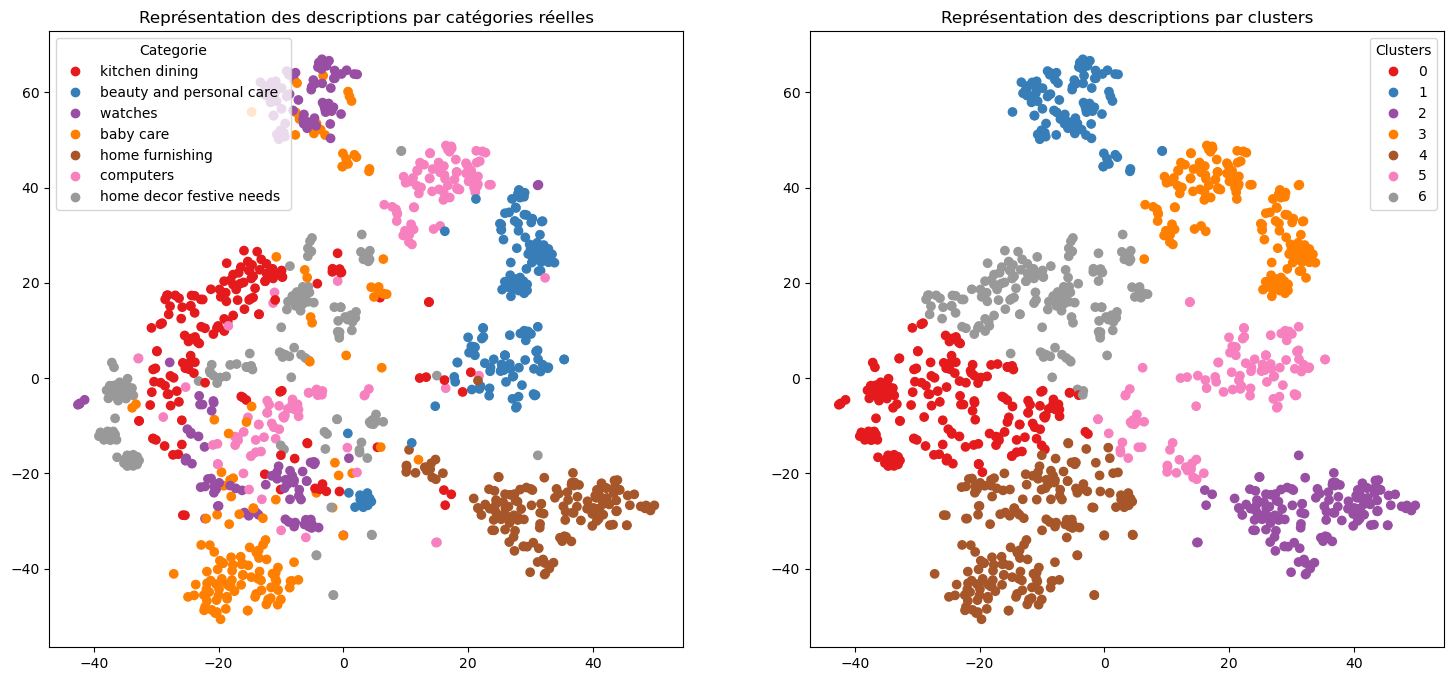

ARI :  0.3606


In [103]:
TSNE_visu_fct(X_tsne_bert, y_cat_num, labels_bert,ARI_bert)

In [104]:
df1['label_bert'] = labels_bert


In [105]:
conf_matrix_bert = confusion_matrix(df1['categ_encode'], df1['label_bert'])
conf_bert = pd.DataFrame(conf_matrix_bert,index=df1['niveau_1'].unique(),columns=df1['label_bert'].unique())
conf_bert

4   2    5   0    1   6   3
home furnishing             7  23    0   1  102   3  14
baby care                  46   0    2  82    7   5   8
watches                     0   0    0  69   12  69   0
home decor festive needs   48   0    3   0   13   8  78
kitchen dining             20  73    0   2   55   0   0
beauty and personal care   66   2    1   0    8  14  59
computers                   0   0  135   0    0  15   0

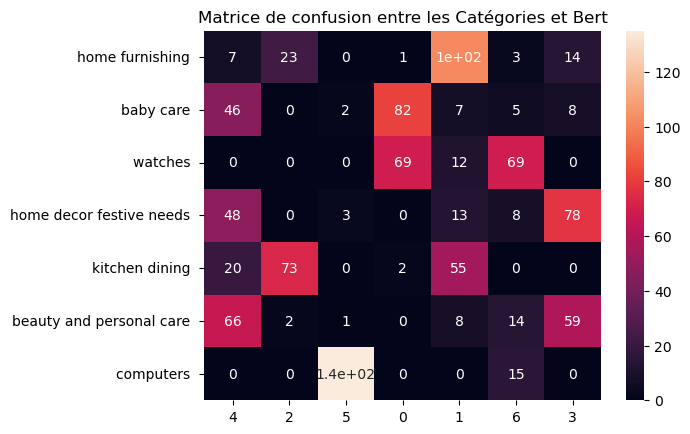

In [106]:
sns.heatmap(conf_bert,annot=True)
plt.title('Matrice de confusion entre les Catégories et Bert')
plt.show()

# USE - Universal Sentence Encoder

In [107]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'




In [108]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.7.0
2.7.0
Num GPUs Available:  0
True


In [109]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [110]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [111]:
df1['description_dl'] = df1['description'].apply(lambda x : transform_dl_fct(x))

In [112]:
batch_size = 150
sentences = df1['description_dl'].to_list()

In [113]:
features_USE = feature_USE_fct(sentences, batch_size)

In [114]:
ARI_use_clean, X_tsne_use_clean, labels_USE = ARI_fct(features_USE)

ARI :  0.4306 time :  7.0


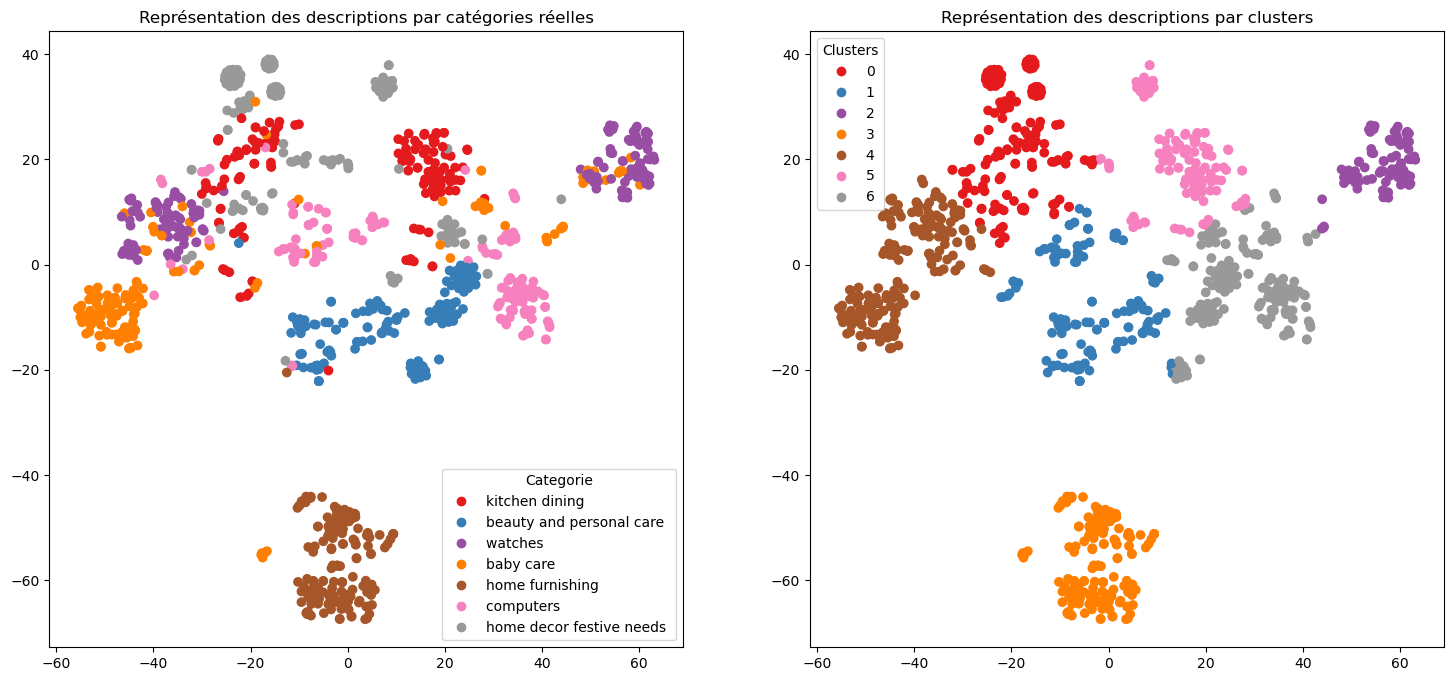

ARI :  0.4306


In [115]:
TSNE_visu_fct(X_tsne_use_clean, y_cat_num, labels_USE, ARI_use_clean)

In [116]:
df1['label_use'] = labels_USE


In [117]:
conf_matrix_use = confusion_matrix(df1['categ_encode'], df1['label_use'])
conf_use = pd.DataFrame(conf_matrix_use,index=df1['niveau_1'].unique(),columns=df1['label_use'].unique())
conf_use

4   3   2    0    1   6   5
home furnishing             3   5  16    5  103   9   9
baby care                   9  41   0    0    6  10  84
watches                     1  81   0    0    0   0  68
home decor festive needs   58   7   0    0    4  74   7
kitchen dining              1   0  74    0   75   0   0
beauty and personal care   92   7   1    0    3  31  16
computers                   0   1   0  149    0   0   0

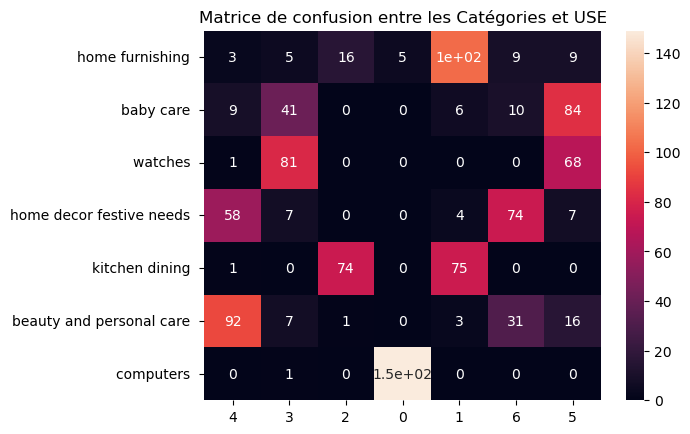

In [118]:
sns.heatmap(conf_use,annot=True)
plt.title('Matrice de confusion entre les Catégories et USE')
plt.show()

# Traitement des images

In [119]:
df3 = pd.merge(df[['uniq_id','image']],df1[['uniq_id','niveau_1','categ_encode']],on='uniq_id',how='inner');
df3 = df3.sort_values(by=['image'], ascending=True)


In [120]:
df3

uniq_id                                 image  \
280  009099b1f6e1e8f893ec29a7023153c4  009099b1f6e1e8f893ec29a7023153c4.jpg   
86   0096e89cc25a8b96fb9808716406fe94  0096e89cc25a8b96fb9808716406fe94.jpg   
724  00cbbc837d340fa163d11e169fbdb952  00cbbc837d340fa163d11e169fbdb952.jpg   
820  00d84a518e0550612fcfcba3b02b6255  00d84a518e0550612fcfcba3b02b6255.jpg   
423  00e966a5049a262cfc72e6bbf68b80e7  00e966a5049a262cfc72e6bbf68b80e7.jpg   
..                                ...                                   ...   
141  feefbdff924dd6b7cc266449c9a36d69  feefbdff924dd6b7cc266449c9a36d69.jpg   
707  ff24511994fc459d04145231c8876d6c  ff24511994fc459d04145231c8876d6c.jpg   
188  ffbf3794aa8cb6bb8d3f313d0a549a09  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   
812  ffc2e1fc7c886ec09a331040ada038aa  ffc2e1fc7c886ec09a331040ada038aa.jpg   
858  fffa2117a4006d4a848eb7d5b80d4816  fffa2117a4006d4a848eb7d5b80d4816.jpg   

                      niveau_1  categ_encode  
280                   watches              6  
86             kitchen dining              5  
724           home furnishing              4  
820  beauty and personal care              1  
423                 computers              2  
..                         ...           ...  
141            kitchen dining              5  
707           home furnishing              4  
188            kitchen dining              5  
812           home furnishing              4  
858                 computers              2  

[1050 rows x 4 columns]

In [121]:
# Création d'une colonne 'path' pour accéder aux images
path = "./Images/"
df3['image_path'] = [path + row for row in df3['image']]

In [122]:
from os import listdir

list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [123]:
categ_liste = list(set(df3['niveau_1']));
categ_liste

['kitchen dining ',
 'beauty and personal care ',
 'watches ',
 'baby care ',
 'home furnishing ',
 'computers ',
 'home decor festive needs ']

kitchen dining 


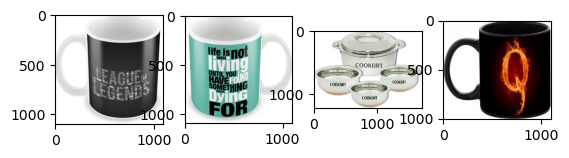

beauty and personal care 


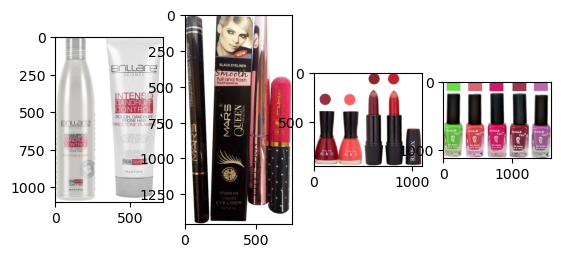

watches 


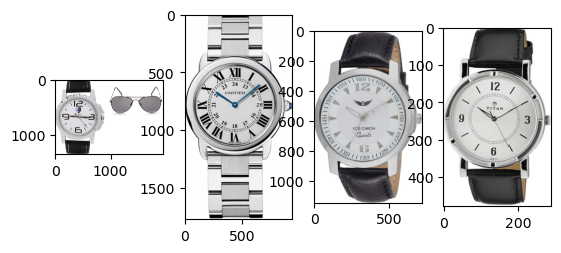

baby care 


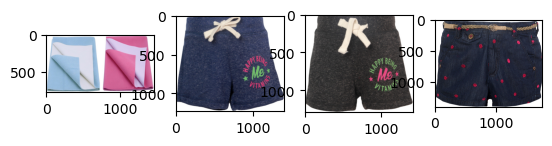

home furnishing 


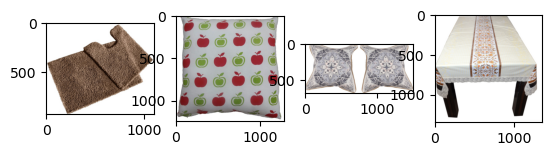

computers 


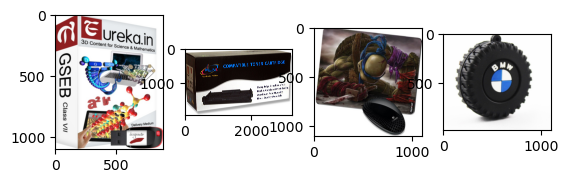

home decor festive needs 


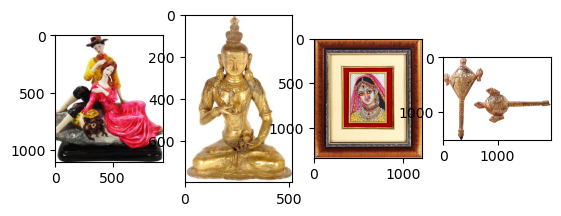

In [124]:
from matplotlib.image import imread

def list_fct(category) :
    list_image_category = [df3['image'][i] for i in range(df3.shape[0])
                       if df3["niveau_1"][i]==category]
    return list_image_category

liste_furnishing=list_fct("home furnishing")
liste_baby=list_fct("baby care")
liste_watches=list_fct("watches")
liste_decor=list_fct("home decor festive needs")
liste_kitchen=list_fct("kitchen dining")
liste_beauty=list_fct("beauty and personal care")
liste_computer=list_fct("computers")



# Show 3 images for each category
for category in categ_liste :
    print(category)
    # print("-------")
    for i in range(4):
        plt.subplot(140 + 1 + i)
        filecategory = './Images/' + list_fct(category)[i+5]
        image = imread(filecategory)
        
        plt.imshow(image)
    plt.show()

# taille des images

In [125]:
import cv2

In [126]:
liste_height = []
liste_width = []

for image_num in range(len(list_photos)):
    image = cv2.imread(path+list_photos[image_num])
   
    liste_height.append(image.shape[0])
    liste_width.append(image.shape[1])
dico_taille = {'width' : liste_width,
               'height':liste_height}
df_taille = pd.DataFrame(dico_taille,index = list_photos)

In [127]:
df_taille.index.rename('image',inplace=True)

In [128]:
df3 = pd.merge(df3,df_taille, on='image', how='inner')

In [129]:
df3

uniq_id                                 image  \
0     009099b1f6e1e8f893ec29a7023153c4  009099b1f6e1e8f893ec29a7023153c4.jpg   
1     0096e89cc25a8b96fb9808716406fe94  0096e89cc25a8b96fb9808716406fe94.jpg   
2     00cbbc837d340fa163d11e169fbdb952  00cbbc837d340fa163d11e169fbdb952.jpg   
3     00d84a518e0550612fcfcba3b02b6255  00d84a518e0550612fcfcba3b02b6255.jpg   
4     00e966a5049a262cfc72e6bbf68b80e7  00e966a5049a262cfc72e6bbf68b80e7.jpg   
...                                ...                                   ...   
1045  feefbdff924dd6b7cc266449c9a36d69  feefbdff924dd6b7cc266449c9a36d69.jpg   
1046  ff24511994fc459d04145231c8876d6c  ff24511994fc459d04145231c8876d6c.jpg   
1047  ffbf3794aa8cb6bb8d3f313d0a549a09  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   
1048  ffc2e1fc7c886ec09a331040ada038aa  ffc2e1fc7c886ec09a331040ada038aa.jpg   
1049  fffa2117a4006d4a848eb7d5b80d4816  fffa2117a4006d4a848eb7d5b80d4816.jpg   

                       niveau_1  categ_encode  \
0                      watches              6   
1               kitchen dining              5   
2              home furnishing              4   
3     beauty and personal care              1   
4                    computers              2   
...                         ...           ...   
1045            kitchen dining              5   
1046           home furnishing              4   
1047            kitchen dining              5   
1048           home furnishing              4   
1049                 computers              2   

                                         image_path  width  height  
0     ./Images/009099b1f6e1e8f893ec29a7023153c4.jpg    687    1162  
1     ./Images/0096e89cc25a8b96fb9808716406fe94.jpg   1478     904  
2     ./Images/00cbbc837d340fa163d11e169fbdb952.jpg   1347     326  
3     ./Images/00d84a518e0550612fcfcba3b02b6255.jpg   1100     857  
4     ./Images/00e966a5049a262cfc72e6bbf68b80e7.jpg    962    1100  
...                                             ...    ...     ...  
1045  ./Images/feefbdff924dd6b7cc266449c9a36d69.jpg   1100     844  
1046  ./Images/ff24511994fc459d04145231c8876d6c.jpg    979    1100  
1047  ./Images/ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   1100     935  
1048  ./Images/ffc2e1fc7c886ec09a331040ada038aa.jpg   1100     943  
1049  ./Images/fffa2117a4006d4a848eb7d5b80d4816.jpg   1100    1077  

[1050 rows x 7 columns]

In [130]:
df3[['height','width']].describe()

height        width
count   1050.000000  1050.000000
mean    1220.038095  1196.570476
std      744.841368   864.076765
min      160.000000   145.000000
25%      844.000000   747.250000
50%     1100.000000  1100.000000
75%     1360.000000  1214.250000
max    11042.000000  8484.000000

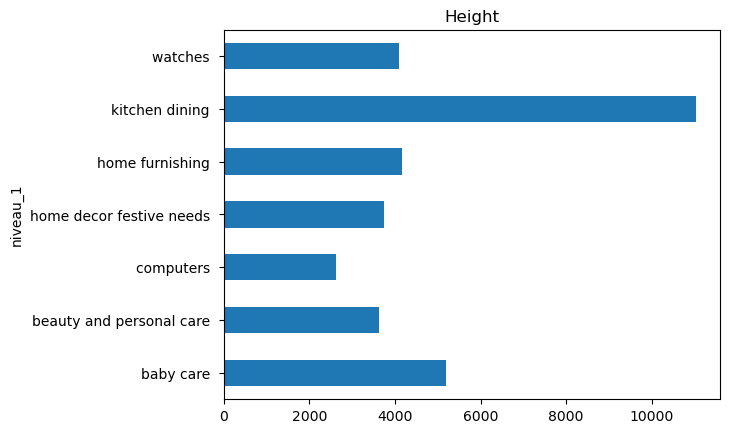

In [131]:
df3.groupby('niveau_1')['height'].max().plot(kind='barh')
plt.title('Height')
plt.show()


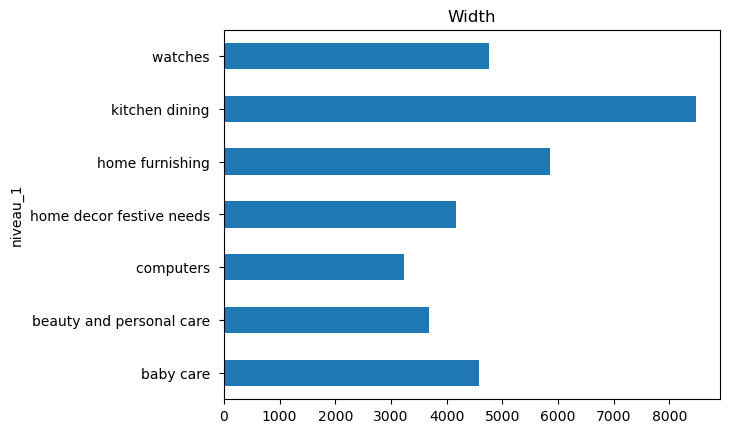

In [132]:
df3.groupby('niveau_1')['width'].max().plot(kind='barh')
plt.title('Width')
plt.show()


[Text(0.5, 1.0, 'width')]

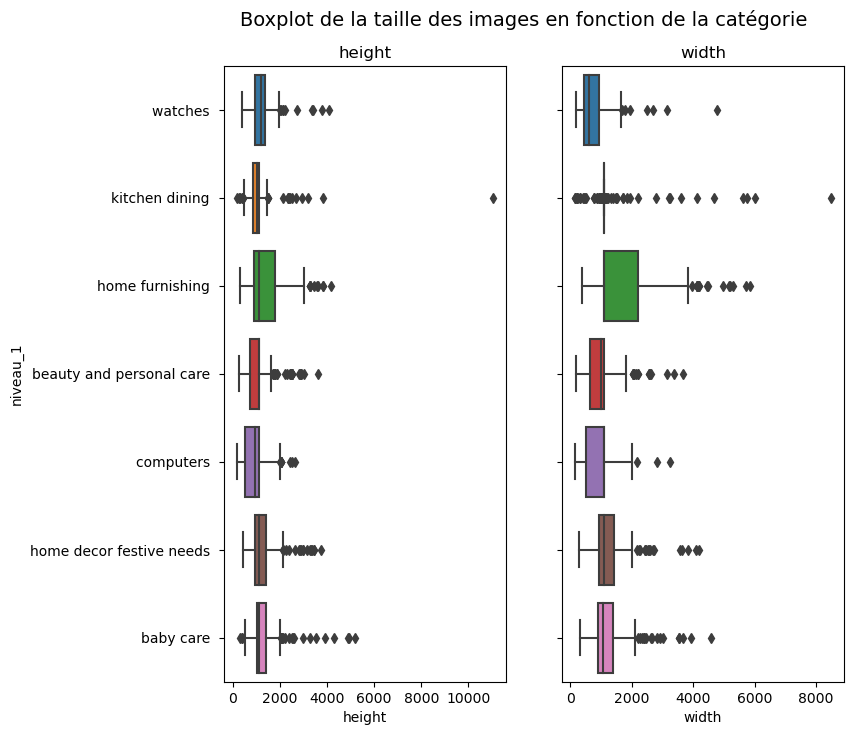

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
#fig.subplots_adjust(hspace=0.2)


fig.suptitle("Boxplot de la taille des images en fonction de la catégorie", fontsize=14, y=0.95)

sns.boxplot(ax=axes[0], data=df3, y='niveau_1', x='height')
axes[0].set(title='height')

sns.boxplot(ax=axes[1], data=df3, y='niveau_1', x='width')
axes[1].set(yticklabels=[]) 
axes[1].set(ylabel=None)
axes[1].set(title='width')

In [134]:
df3['ratio'] = df3['width']/df3['height']

<AxesSubplot: >

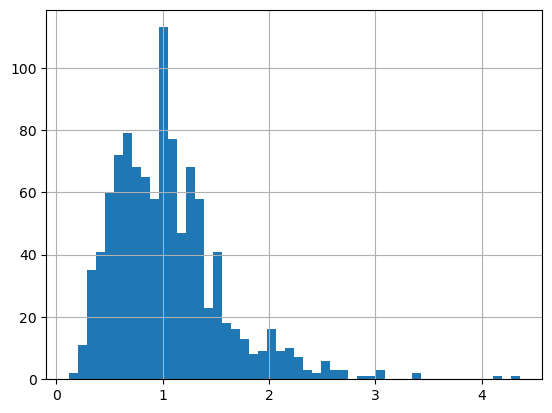

In [135]:
df3['ratio'].hist(bins=50,)

In [136]:
df3.groupby('niveau_1')['ratio'].value_counts()

niveau_1    ratio   
baby care   0.750000    7
            1.000000    4
            0.244769    1
            0.293636    1
            0.307203    1
                       ..
watches     1.375320    1
            1.439124    1
            1.450484    1
            1.792123    1
            1.987961    1
Name: ratio, Length: 914, dtype: int64

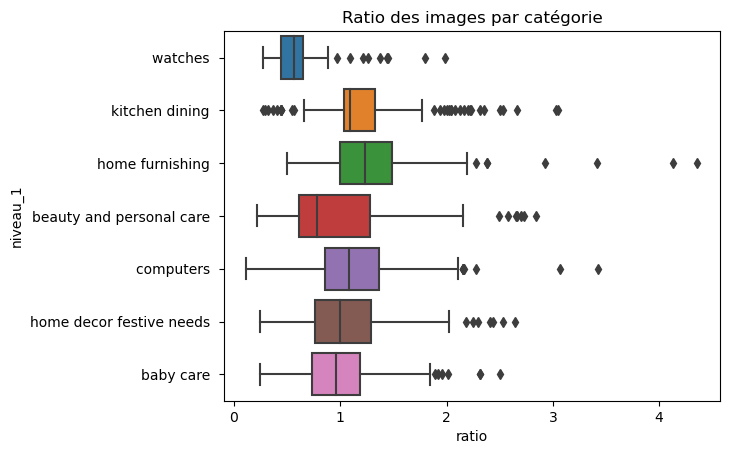

In [137]:
sns.boxplot(data=df3, y='niveau_1', x='ratio')
plt.title('Ratio des images par catégorie')
plt.show()

# SIFT

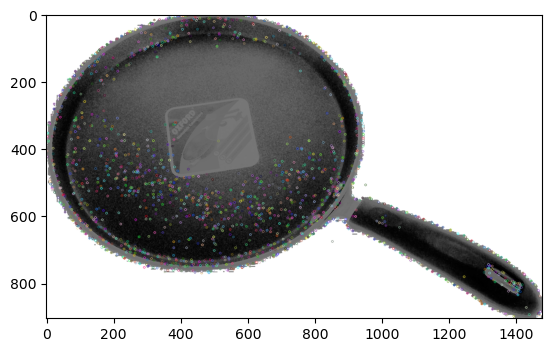

Descripteurs :  (2028, 128)

[[52. 40. 16. ... 99. 12.  0.]
 [ 2.  0.  1. ...  0.  0.  0.]
 [48.  0.  0. ...  0.  1.  0.]
 ...
 [ 0.  0.  0. ...  0.  4.  1.]
 [45.  0.  0. ...  3. 34.  7.]
 [ 1. 10.  7. ...  0.  0.  0.]]


In [138]:
import time, cv2
# Test sift sur une image 
sift = cv2.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
image = cv2.medianBlur(image,3)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


**Créations des descripteurs de chaque image**
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [139]:
# identification of key points and associated descriptors in list_photos

temps1=time.time()


sift = cv2.SIFT_create()
clahe = cv2.createCLAHE()

# Apply pre processing and descriptors creation for list1
sift_keypoints = []
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread('./Images/'+list_photos[image_num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    res = cv2.medianBlur(res, 3)
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)


# Create a list of descriptors for each image 
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype='object')

# Create a list of descriptors of all images 
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (7777464, 128)
temps de traitement SIFT descriptor :           355.08 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [140]:
from sklearn import cluster, metrics

temps1=time.time()

# Determination number of clusters (using square root of the number of descriptors)
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k,init_size = 3*k,batch_size=4096, random_state=40)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  2789
Création de 2789 clusters de descripteurs ...
temps de traitement kmeans :           159.73 secondes


## Création des features des images
Pour chaque image :  

* prédiction des numéros de cluster de chaque descripteur
* création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
* Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [141]:
# Creation of histograms (features)
temps1=time.time()

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

# define the matrix of histograms
im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            73.79 secondes


## Réductions de dimension

Réduction de dimension PCA :  

* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [142]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2789)
Dimensions dataset après réduction PCA :  (1050, 750)


## Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [143]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne_sift = tsne.fit_transform(feat_pca)

df_tsne_sift = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_sift["class"] = df3["niveau_1"]
print(df_tsne_sift.shape)

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

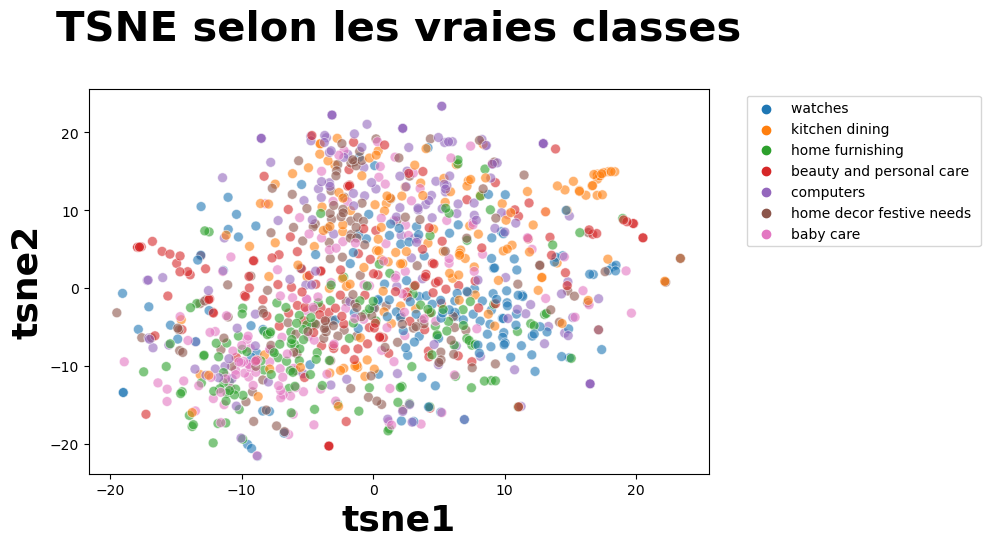

In [144]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_sift, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()


## Analyse mesures : similarité entre catégories et clusters
* Création de clusters à partir du T-SNE

In [145]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=40)
cls.fit(X_tsne_sift)

df_tsne_sift["cluster"] = cls.labels_
print(df_tsne_sift.shape)

(1050, 4)


## Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

In [146]:
from sklearn.metrics import accuracy_score

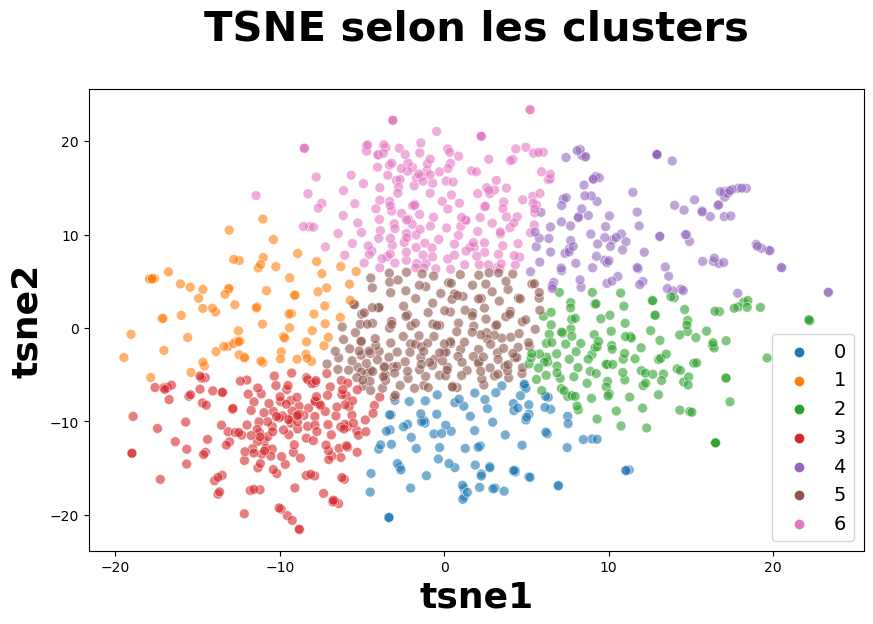

ARI :  0.06933397260097114


In [147]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_sift,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels_sift = df3["categ_encode"]
print("ARI : ", metrics.adjusted_rand_score(labels_sift, cls.labels_))
#print('Accuracy: {}'.format(accuracy_score(labels, cls.labels_)))

In [148]:
df3['label_sift'] = cls.labels_
conf_matrix_sift = confusion_matrix(df3['categ_encode'], df3['label_sift'])

In [149]:
conf_matrix_sift

array([[13,  6,  9, 57, 10, 32, 23],
       [16, 35,  6,  8, 21, 50, 14],
       [11,  7, 20, 17, 23,  8, 64],
       [14, 12, 17, 22,  8, 35, 42],
       [24,  7, 17, 60,  9, 29,  4],
       [10,  6, 17,  7, 46, 24, 40],
       [13, 14, 59, 15, 10, 26, 13]], dtype=int64)

In [150]:
conf_sift = pd.DataFrame(conf_matrix_sift,index=df3['niveau_1'].unique(),columns=df3['label_sift'].unique())
conf_sift

3   6   1   2   4   5   0
watches                    13   6   9  57  10  32  23
kitchen dining             16  35   6   8  21  50  14
home furnishing            11   7  20  17  23   8  64
beauty and personal care   14  12  17  22   8  35  42
computers                  24   7  17  60   9  29   4
home decor festive needs   10   6  17   7  46  24  40
baby care                  13  14  59  15  10  26  13

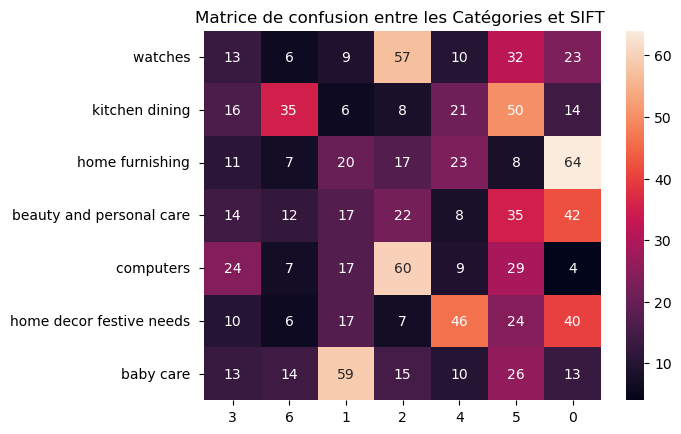

In [151]:
sns.heatmap(conf_sift,annot=True,xticklabels=True, yticklabels=True)
plt.title('Matrice de confusion entre les Catégories et SIFT ')
plt.show()

# CNN : VGG16

In [152]:
import numpy as np
from sklearn import cluster, metrics
from keras import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from tensorflow.keras.preprocessing import image

In [153]:
# load model
model_vgg16 = VGG16()
# remove the output layer
model_vgg16 = Model(inputs = model_vgg16.inputs,
                    outputs = model_vgg16.layers[-2].output)
# summarize the model
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [154]:
vgg16_feature_list = []

for i, fname in enumerate(list_photos):

    img = image.load_img('./Images/'+list_photos[i], target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data =preprocess_input(img_data)
    

    vgg16_feature = model_vgg16.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())    
    
        
vgg16_feature_list_np = np.array(vgg16_feature_list)

C:\Users\sarah\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [155]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", vgg16_feature_list_np.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


In [156]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df3["niveau_1"]
print(df_tsne.shape)

C:\Users\sarah\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


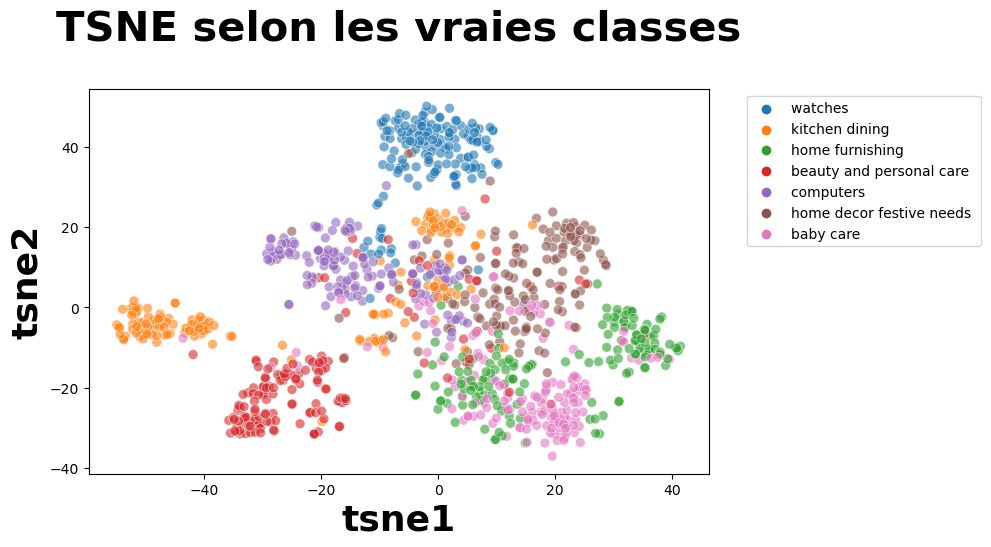

In [157]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

In [158]:
from sklearn import cluster, metrics

kmeans = cluster.KMeans(n_clusters=7, random_state=40).fit(vgg16_feature_list_np)


df_tsne["cluster"] = kmeans.labels_
print(df_tsne.shape)

(1050, 4)


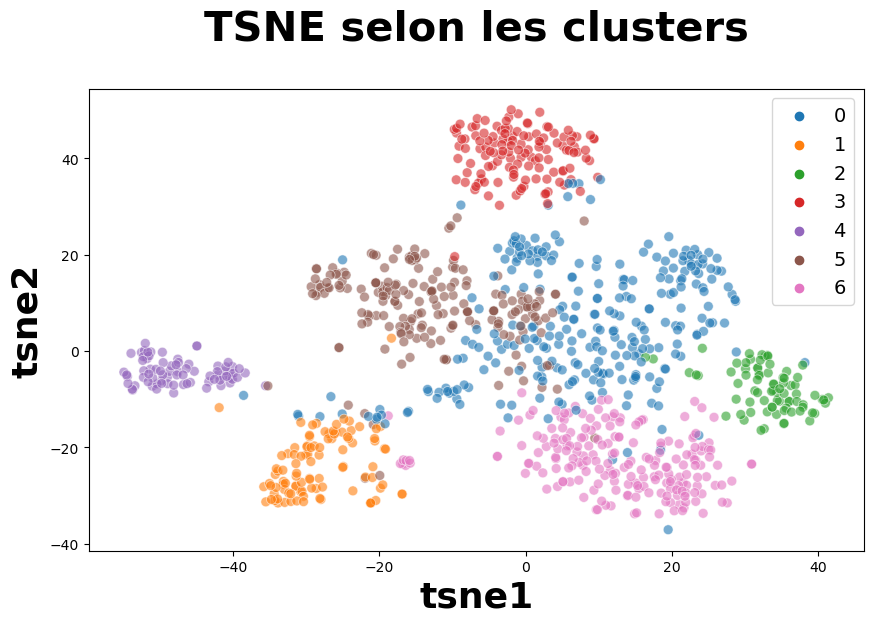

ARI :  0.47432012918844274


In [159]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df3["categ_encode"]
print("ARI : ", metrics.adjusted_rand_score(labels, kmeans.labels_))


In [160]:
df3['label_cnn'] = kmeans.labels_
conf_matrix_cnn = confusion_matrix(df3['categ_encode'], df3['label_cnn'])

In [161]:
conf_matrix_cnn

array([[ 28,   2,  10,   0,   1,   3, 106],
       [ 25,  95,   1,   0,   0,  16,  13],
       [ 10,   1,   0,   0,   0, 139,   0],
       [140,   0,   4,   2,   0,   2,   2],
       [  7,   0,  63,   0,   0,   0,  80],
       [ 58,   1,   0,   0,  76,  14,   1],
       [  8,   0,   0, 127,   0,  15,   0]], dtype=int64)

In [162]:
conf_cnn = pd.DataFrame(conf_matrix_cnn,index=df3['niveau_1'].unique(),columns=df3['label_cnn'].unique())
conf_cnn

0   5   6    1   4    3    2
watches                     28   2  10    0   1    3  106
kitchen dining              25  95   1    0   0   16   13
home furnishing             10   1   0    0   0  139    0
beauty and personal care   140   0   4    2   0    2    2
computers                    7   0  63    0   0    0   80
home decor festive needs    58   1   0    0  76   14    1
baby care                    8   0   0  127   0   15    0

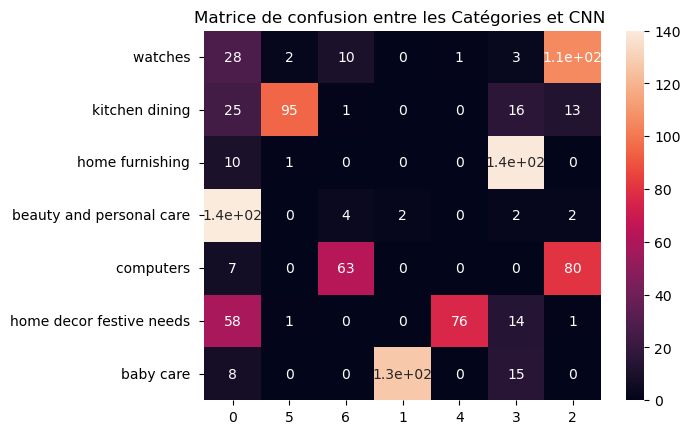

In [163]:
sns.heatmap(conf_cnn,annot=True,xticklabels=True, yticklabels=True)
plt.title('Matrice de confusion entre les Catégories et CNN ')
plt.show()

# POC : Image et texte

In [164]:
# Bag of word
texte_CV_clean = pd.DataFrame(X_tsne_cv_lem, columns=['tsne1', 'tsne2']) 


# TD-idf
texte_td_lem = pd.DataFrame(X_tsne_tdif_lem, columns=['tsne1', 'tsne2'])

# Word2Vec
texte_w2v_clean = pd.DataFrame(X_tsne_w2_clean, columns=['tsne1', 'tsne2'])

# bert
texte_bert_clean = pd.DataFrame(X_tsne_bert, columns=['tsne1', 'tsne2'])


# USE
texte_USE_clean = pd.DataFrame(X_tsne_use_clean, columns=['tsne1', 'tsne2'])


# IMAGE

# SIFT
image_sift = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])

#CNN
image_cnn = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])

In [165]:
# Création de deux dictionnaires afin de faire une boucle pour tester les modèles
dico_texte = {'CountVectorizer' : texte_CV_clean,
              'Tf-idf' : texte_td_lem,
              'Word2Vec' : texte_w2v_clean,
              'Bert' : texte_bert_clean,
              'Use' : texte_USE_clean,
                 
}

dico_image = { 'SIFT' : image_sift,
              'CNN' : image_cnn
    
}

CountVectorizer/SIFT
ARI : 0.4866


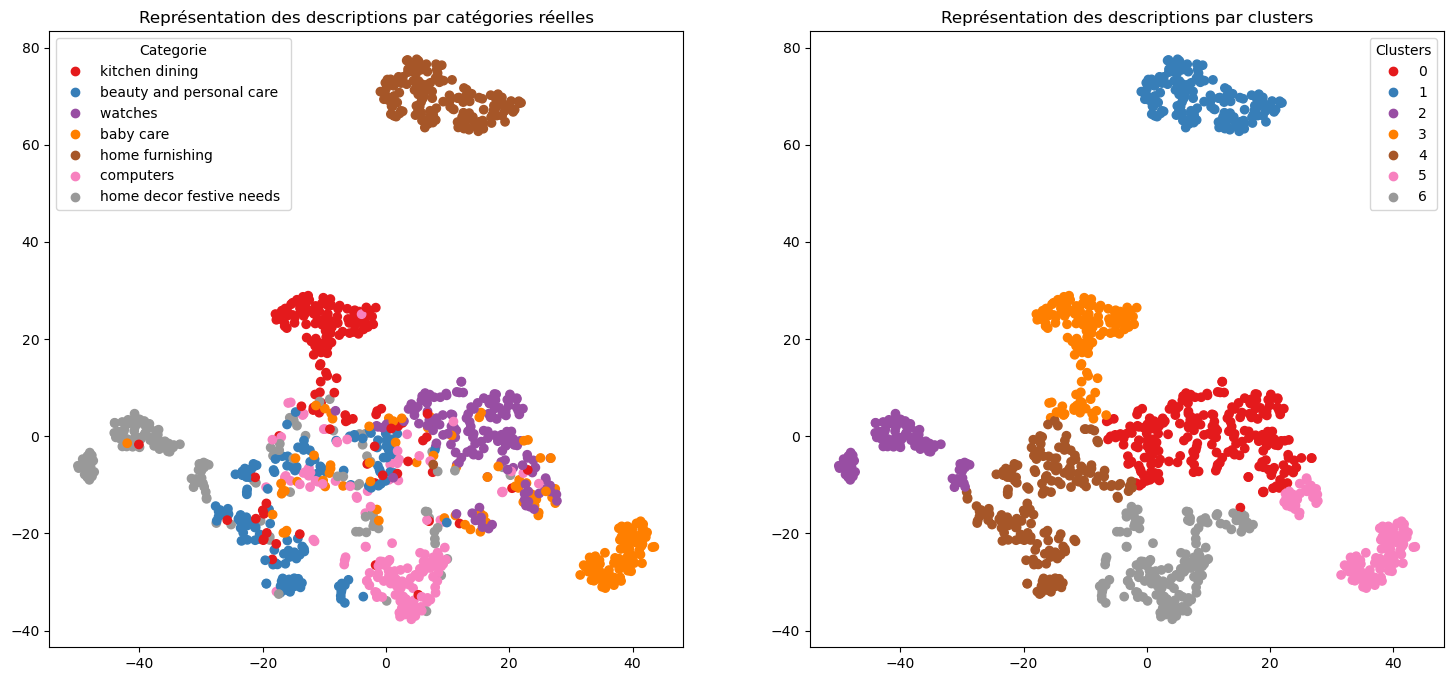

-------------------------
CountVectorizer/CNN
ARI : 0.2376


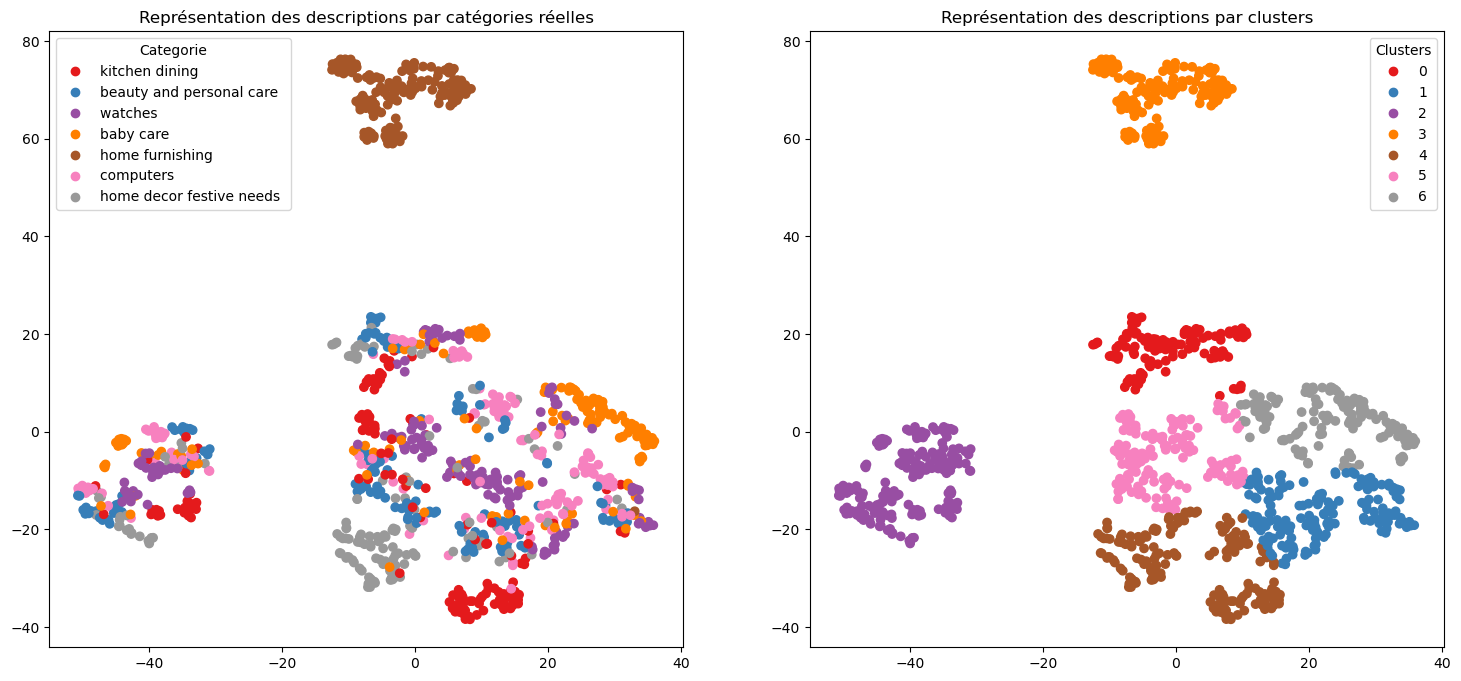

-------------------------
Tf-idf/SIFT
ARI : 0.5356


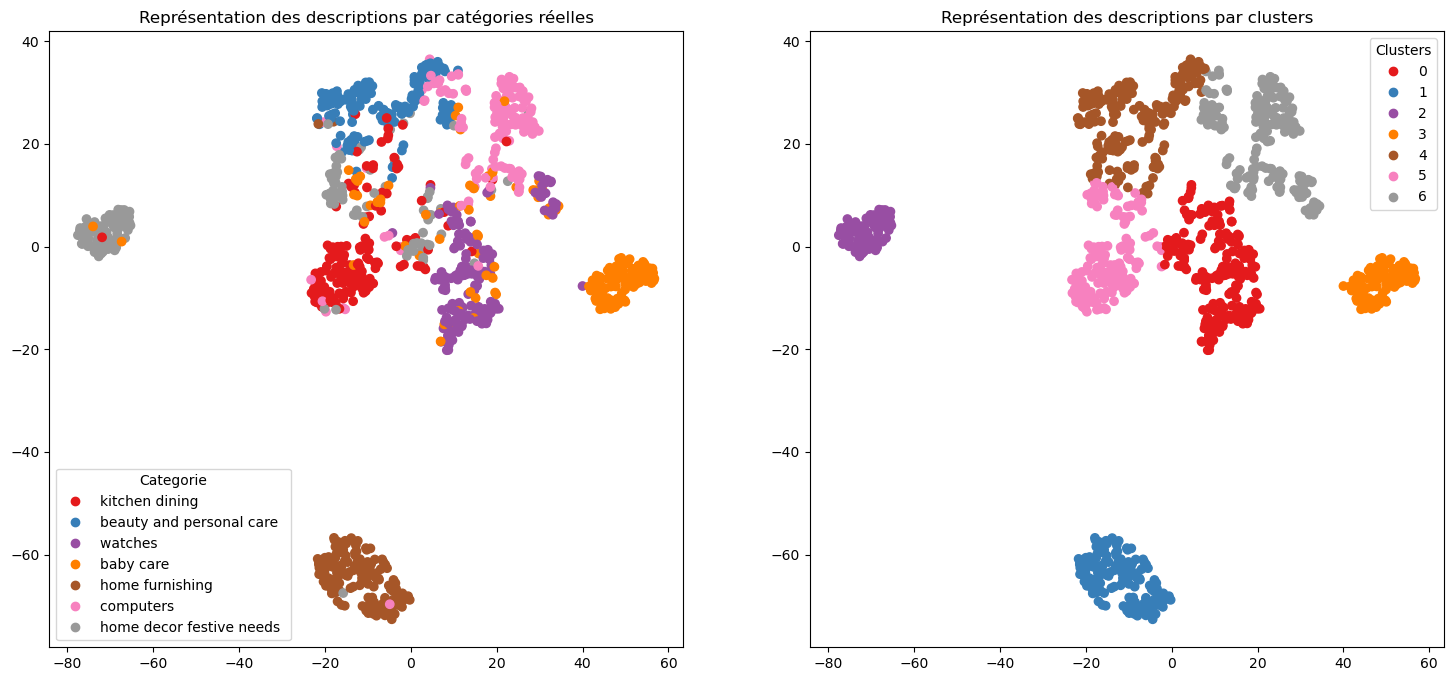

-------------------------
Tf-idf/CNN
ARI : 0.2676


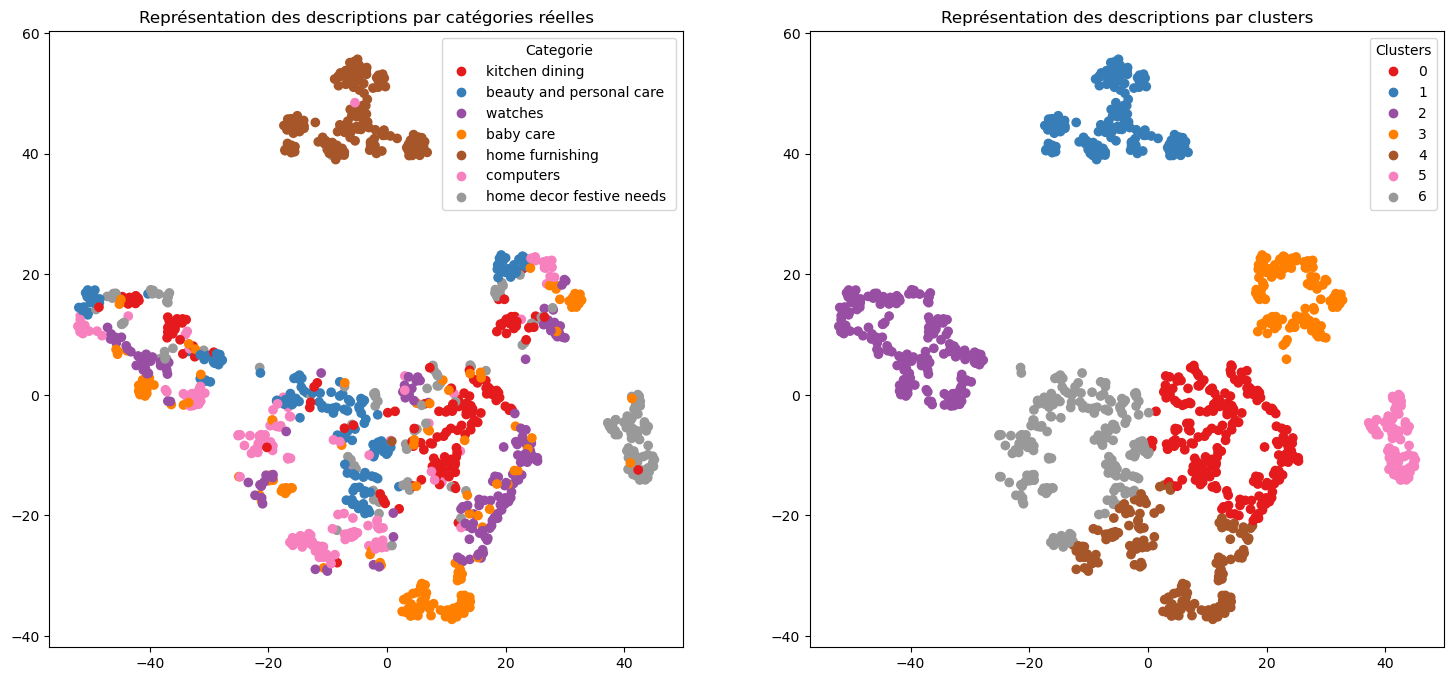

-------------------------
Word2Vec/SIFT
ARI : 0.4671


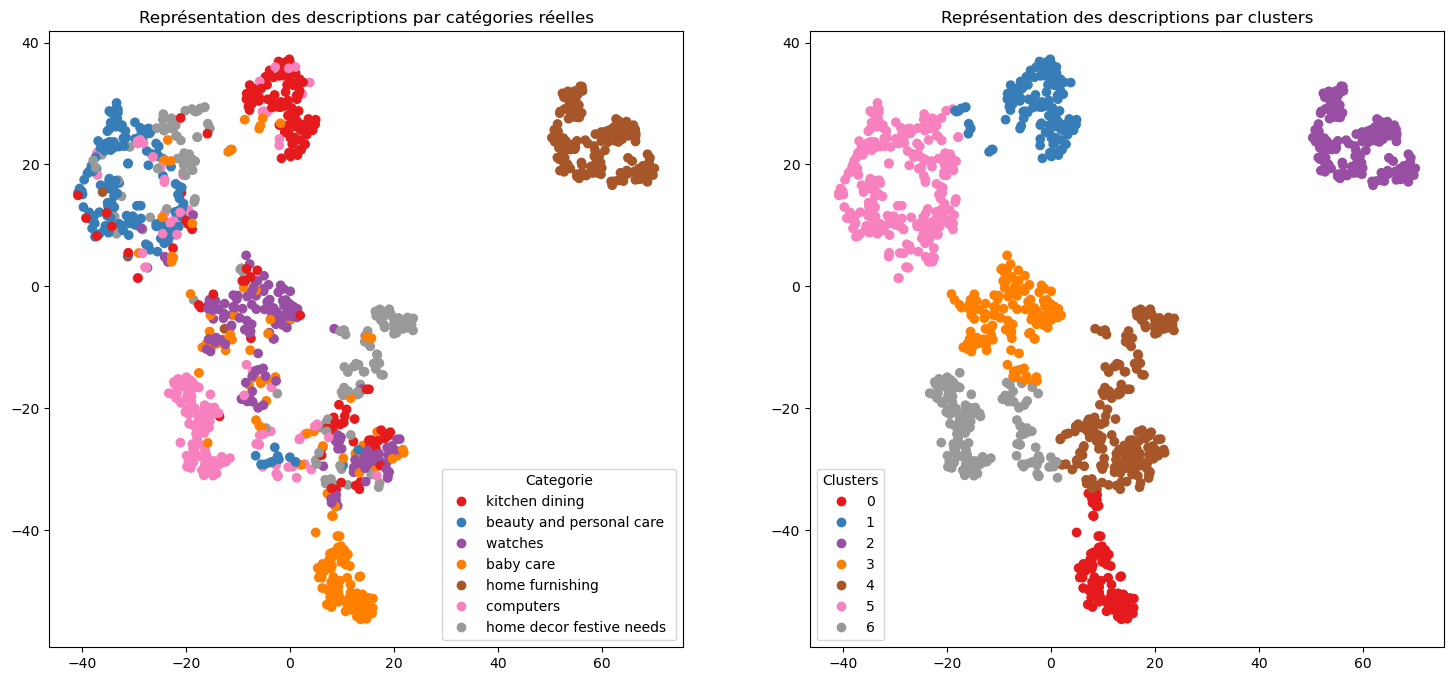

-------------------------
Word2Vec/CNN
ARI : 0.2153


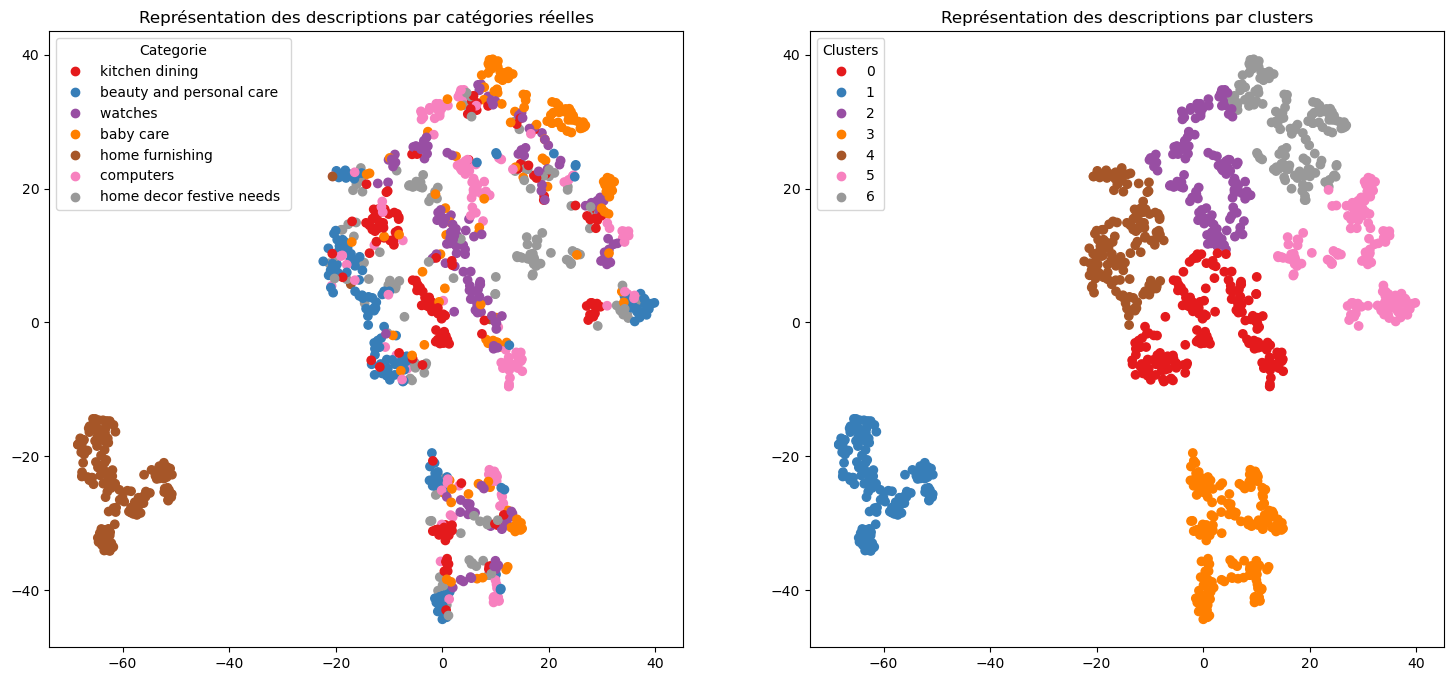

-------------------------
Bert/SIFT
ARI : 0.3357


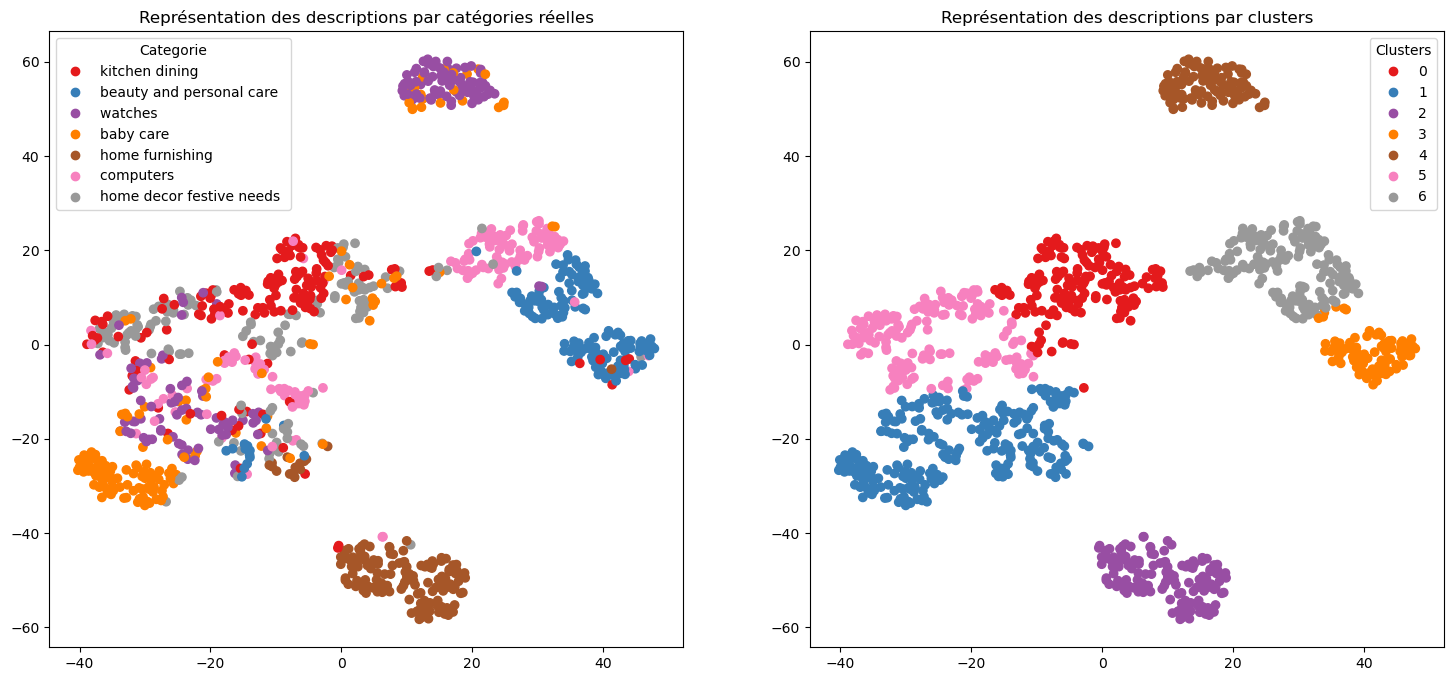

-------------------------
Bert/CNN
ARI : 0.2579


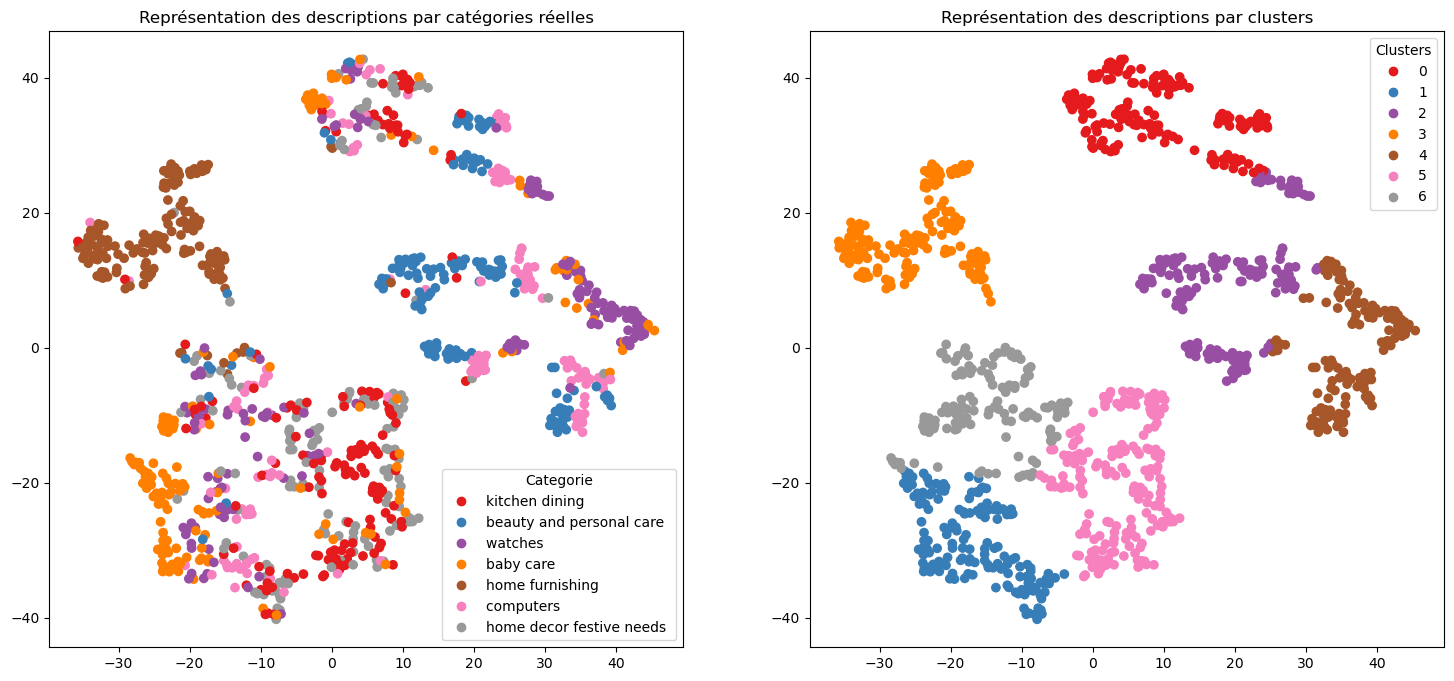

-------------------------
Use/SIFT
ARI : 0.4264


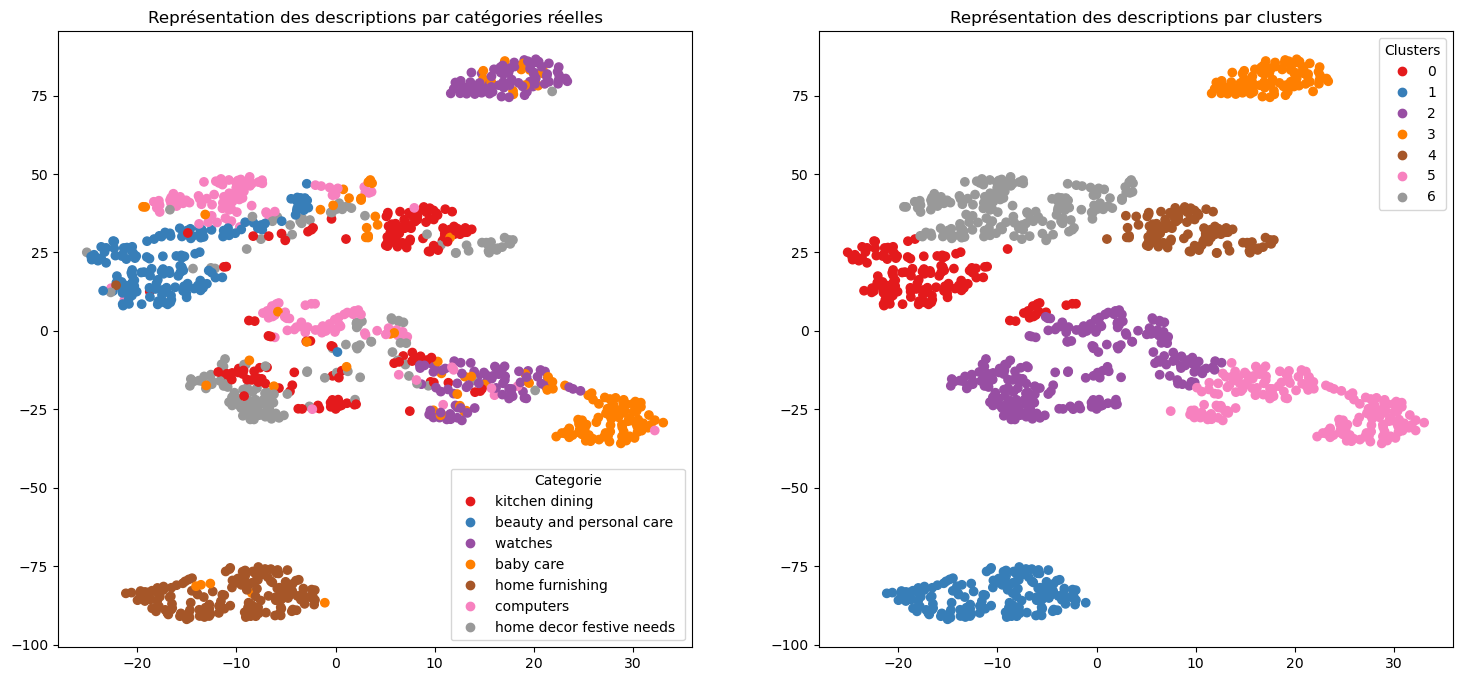

-------------------------
Use/CNN
ARI : 0.2436


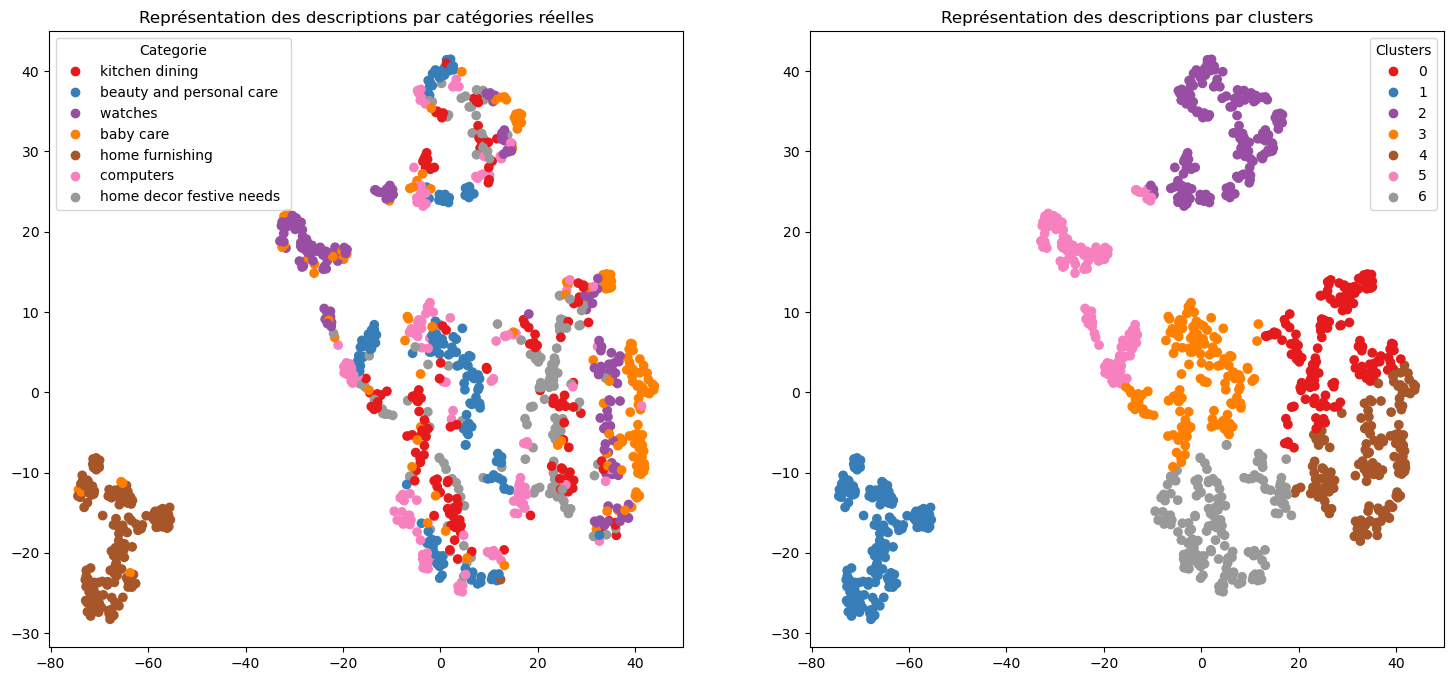

-------------------------


In [166]:
texte =[]
image = []
results = []
for texte_key, texte_value in dico_texte.items():
   
    for image_key, image_value in dico_image.items():
        texte.append(texte_key+"/"+image_key) 
        image.append(image_key)
        features = pd.concat([texte_value, image_value], axis=1)
        ARI_1, X_tsne_1, labels = ARI_fct_2(features)
        print(texte_key+"/"+image_key)
        print('ARI :', ARI_1)
        results.append(ARI_1)
        TSNE_visu_fct_2(X_tsne_1, y_cat_num, labels,ARI_1)
        print('-'*25)
        
    
   

In [167]:
df_modele = pd.DataFrame(results,index=texte,columns=['Score ARI'])

In [168]:
df_modele = df_modele.reset_index()
df_modele = df_modele.sort_values('Score ARI',ascending=False)

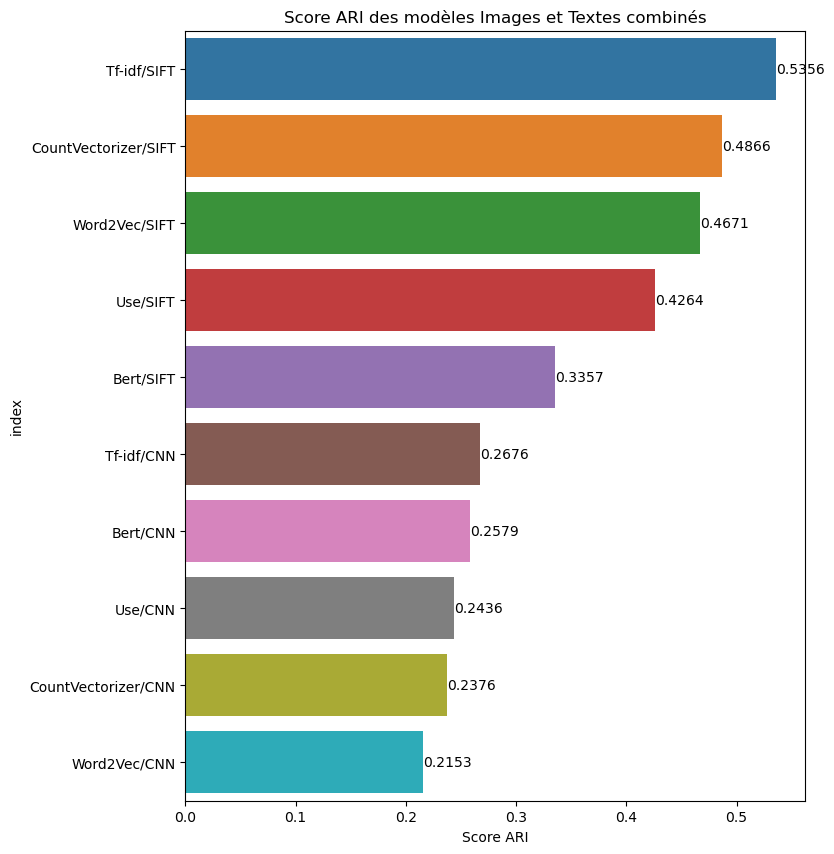

In [169]:
plt.figure(figsize=(8, 10))
ax1 = sns.barplot(data = df_modele,y='index',x='Score ARI')
ax1.bar_label(ax1.containers[0])
plt.title('Score ARI des modèles Images et Textes combinés')
plt.show()